# **Organización de Datos**

### Trabajo Práctico N°1: TLC Trip Record Data

Grupo 02 - Célestine Raveneau, Florian Escaffre, Juan Gomez, Luis Condori

Cátedra Ing. Rodriguez, Juan Manuel - 2C2024

#EJ 3 - Airbnb ROME

## Setup and Data Import

### Includes

In [120]:
!pip install plotly_express

import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 30)

import seaborn as sns
import numpy as np
import plotly_express as px
import matplotlib.pyplot as plt

from scipy.spatial.distance import mahalanobis

from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor

from matplotlib import pyplot as plt
from scipy.stats import chi2_contingency
import pyarrow.parquet as pq
from datetime import date

### Getting the datasets from the drive

In [121]:
from google.colab import drive
drive.mount('/content/drive')

listings_short=pd.read_csv('/content/drive/MyDrive/Ta047-tp_2do_cuat_2024_grupo_2/Data/EJ3/listings.csv')
listings_long=pd.read_csv('/content/drive/MyDrive/Ta047-tp_2do_cuat_2024_grupo_2/Data/EJ3/listings_long_version.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Choosing which file to work on
(All this part was not asked for you can skip to a) Análisis Exploratorio y preprocesamiento de datos)



### Files available for Rome in the website
- listings
  - short version
  - long version with more columns
- reviews
  - long version (id, date, comment)
  - short version (id, date)
-neighbourhood (should give us neighbourhood_group for each neighbourhood but the column is empty)
-neighbourhoods.geojson (says which coordinates belong to which neighbourhood

The files that could interest us are the long and short version of listings

### Outline
We will analyse the content of both to choose if we should work with the long version, the short version or a combination of the two.

We will then continue with a breif data analysis to see what variables interest us most before move on with the data cleaning and data transformation

Once all of this is done we will be able to train different models with our datas and compare the results.


Let's first see if there is the same number of data in each file.

In [122]:
print("Number of lignes in the short version :", listings_short.shape[0])
print("Number of lignes in the long version :", listings_long.shape[0])

Number of lignes in the short version : 32243
Number of lignes in the long version : 34061


#### Comparison of the number of NaNs in each file.

In [123]:
nan_percent_short = listings_short.isna().mean() * 100
nan_count_long = listings_long.isna().mean() * 100

common_columns = listings_short.columns.intersection(listings_long.columns)

nan_comparison = pd.DataFrame({
    'NaN % (listing_short)': nan_percent_short[common_columns],
    'NaN % (listing_long)': nan_count_long[common_columns]
})

print(nan_comparison)

                                NaN % (listing_short)  NaN % (listing_long)
id                                           0.000000              0.000000
name                                         0.000000              0.000000
host_id                                      0.000000              0.000000
host_name                                    0.003101              0.000000
neighbourhood                                0.000000             43.912392
latitude                                     0.000000              0.000000
longitude                                    0.000000              0.000000
room_type                                    0.000000              0.000000
price                                       10.994634             11.053698
minimum_nights                               0.000000              0.000000
number_of_reviews                            0.000000              0.000000
last_review                                 14.133300             14.890931
reviews_per_

All of the columns for the short version are in the long one too.

When I first analysed this I did not realise that the neighbourhood column had a "cleaned" version in listings_long and thus combining both files would not add much value. Thus I did an analisis of how much lines are in commun between both files, which I left below.

However with this information in mind, we can directly pick listings_long.


####  Inner join to see how many lines are in commun

To choose if a combination of both files would be possible, we need to know how many lines they have in commun.

We are going to do an inner join, for which we need not to have any duplicate considering the commun columns with no NaNs between the two files (excluding id)

Transforming price into an int in the long version so that both versions have the same data type for price

In [124]:
listings_long['price'] = listings_long['price'].str.replace('$', '').str.replace(',', '').astype(float)

Finding out the commun columns without NaNs

In [125]:
# Find common columns between listings_long and listings_short
common_columns = list(set(listings_long.columns).intersection(set(listings_short.columns)))

# Filter out columns with NaNs in either listings_long or listings_short
columns_without_nans = []
for col in common_columns:
  if listings_long[col].notna().all() and listings_short[col].notna().all():
    columns_without_nans.append(col)

columns_without_nans.remove('id')
print("Common columns without NaNs:")
print(columns_without_nans)


Common columns without NaNs:
['host_id', 'number_of_reviews', 'calculated_host_listings_count', 'minimum_nights', 'latitude', 'name', 'room_type', 'availability_365', 'longitude', 'number_of_reviews_ltm']


Cheking for duplicate considering thoses columns.

In [126]:
pd.set_option('display.max_columns', 20)
duplicates = listings_long[listings_long.duplicated(subset=columns_without_nans, keep=False)]

print("Number of duplicates :", len(duplicates))
print(duplicates[['id', 'description']])
id_duplicate = duplicates['id'].iloc[0]


Number of duplicates : 2
                        id                                        description
32086  1192070747028414787  Relax with the whole family at this peaceful p...
32167  1192748198713818341  You’ll be charmed by this adorable place to st...


The datas are duplicates considering only the columns we will join upon (but not considering all columns), thus we will create a data frame without one of them for the join

Getting rid of the "duplicate"

In [127]:
listings_long_for_join = listings_long.drop(listings_long[listings_long['id'] == id_duplicate ].index)

Same for the short version

In [128]:
pd.set_option('display.max_columns', 20)
duplicates = listings_short[listings_short.duplicated(subset=['name','host_id','room_type','longitude','latitude','minimum_nights','number_of_reviews','availability_365','calculated_host_listings_count','number_of_reviews_ltm'], keep=False)]

print("Number of duplicates :", len(duplicates))
print(duplicates[['id']])
id_duplicate = id_duplicate = duplicates['id'].iloc[0]

Number of duplicates : 2
                        id
31994  1172977129296583972
31995  1172998319181271741


In [129]:
listings_short_for_join = listings_short.drop(listings_long[listings_long['id'] == id_duplicate].index)

Now that we are sure not to have any duplicates let's see how many line we have in each data set and if we combine both

In [130]:
#Calculating the number of line in commun
#Since the ids are not the same for the appartement we are considering that if two appartements have the same host_name and price it is the same appartment.
columns_to_merge_on = ['name','host_id','room_type','longitude','latitude','minimum_nights','number_of_reviews','availability_365','calculated_host_listings_count','number_of_reviews_ltm']
matching_rows = pd.merge(
    listings_long_for_join[columns_to_merge_on],
    listings_short_for_join[columns_to_merge_on],
    on=columns_to_merge_on,
    how='inner'
)
print("Number of lignes in commun to both versions :", len(matching_rows))

Number of lignes in commun to both versions : 2515


As we can see there are very few lines I commun between both files, thus we don't have the option of combining both and we have to choose one.

# a) Análisis Exploratorio y preprocesamiento de datos

##Droping the columns that don't interest us

Considering the important number of columns we will be deleting those that are redondant or that don't give relevant information before further analysing the data.

#### Correlation between price and other numerical variables

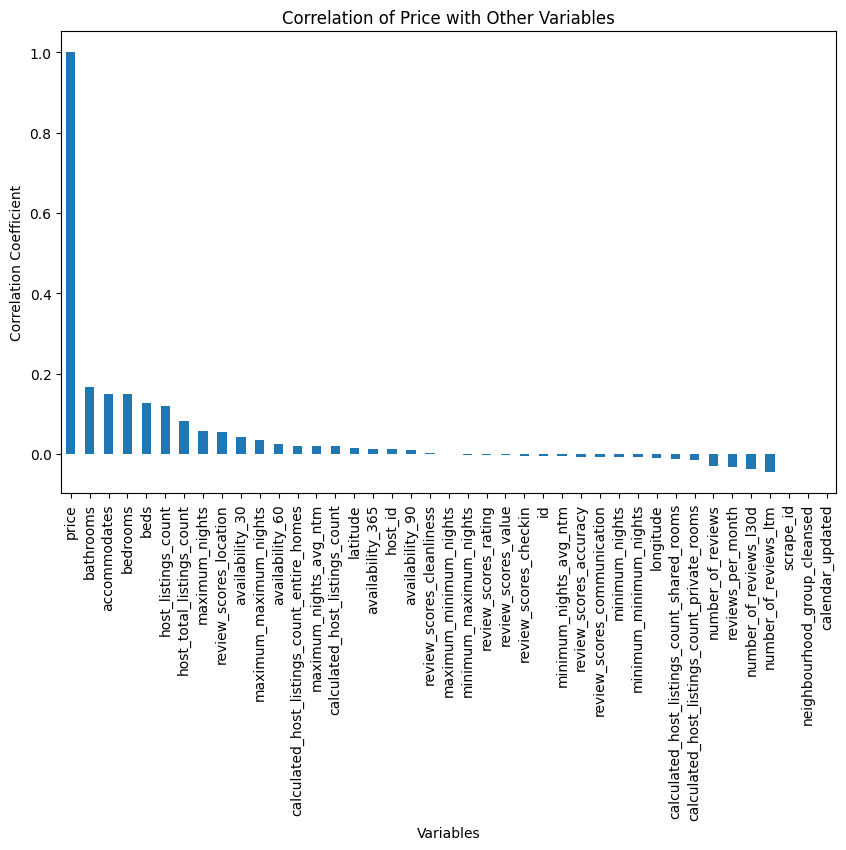

In [131]:
# Select the 'price' column and other relevant numerical columns
numerical_data = listings_long.select_dtypes(include=np.number)
price_corr = numerical_data.corr()['price']

# Sort the correlations in descending order
price_corr = price_corr.sort_values(ascending=False)

# Create a bar plot to visualize the correlations
plt.figure(figsize=(10, 6))
price_corr.plot(kind='bar')
plt.title('Correlation of Price with Other Variables')
plt.xlabel('Variables')
plt.ylabel('Correlation Coefficient')
plt.show()

#### Looking at boxplot for each numerical variable to spot non-linear relations that wouldn't appear on the correlation graph but would stil be useful.

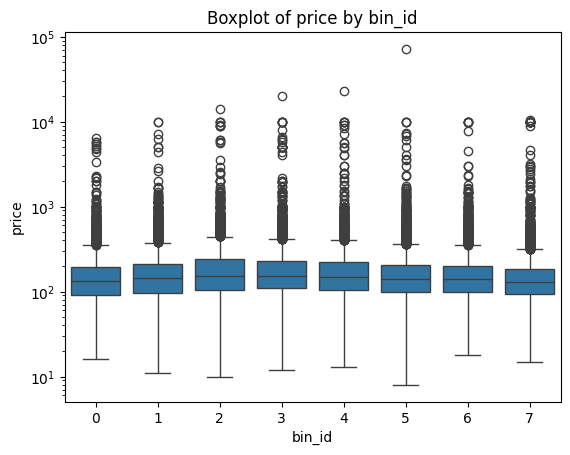

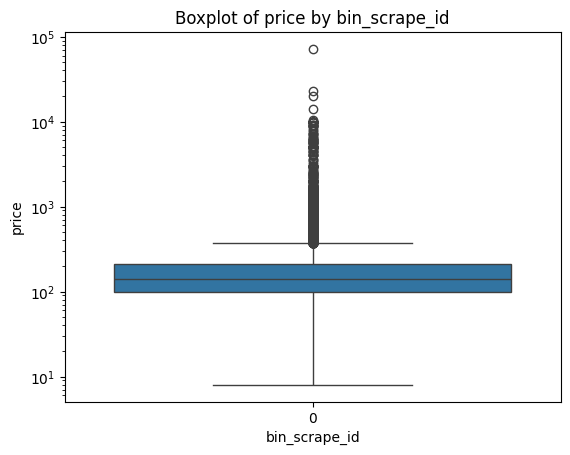

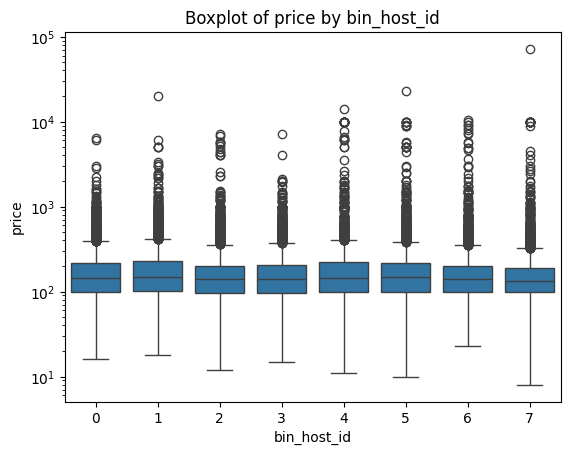

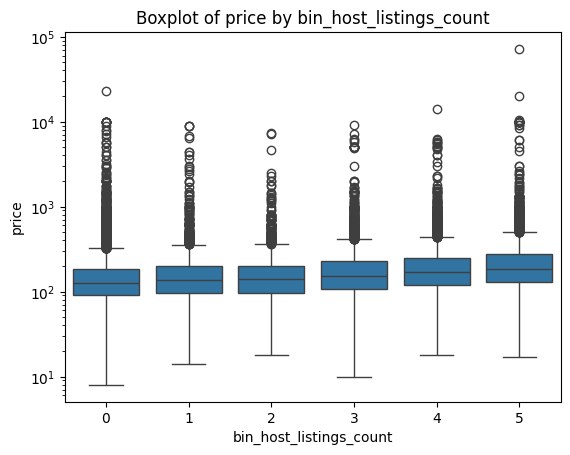

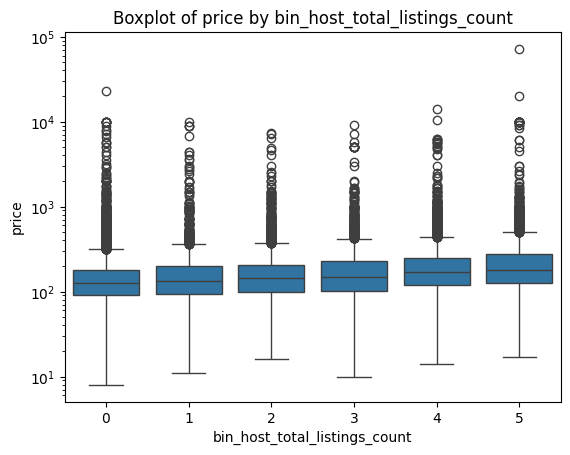

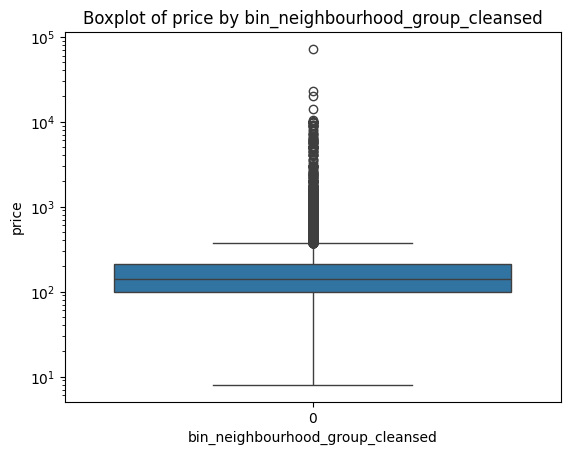

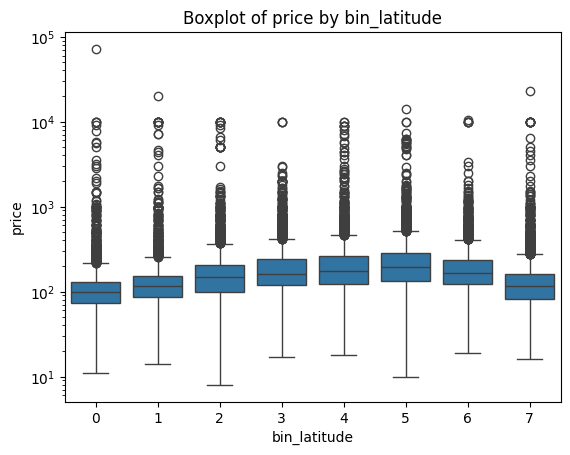

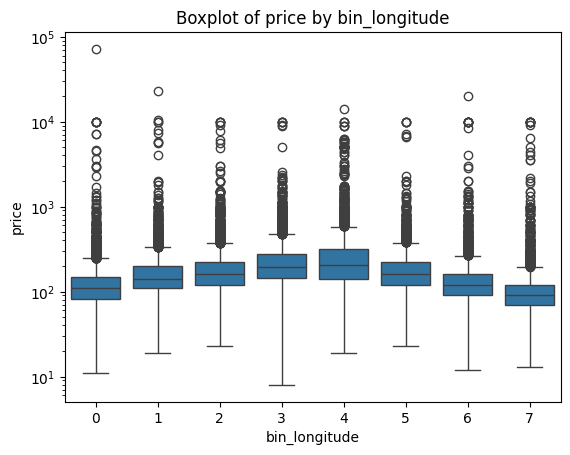

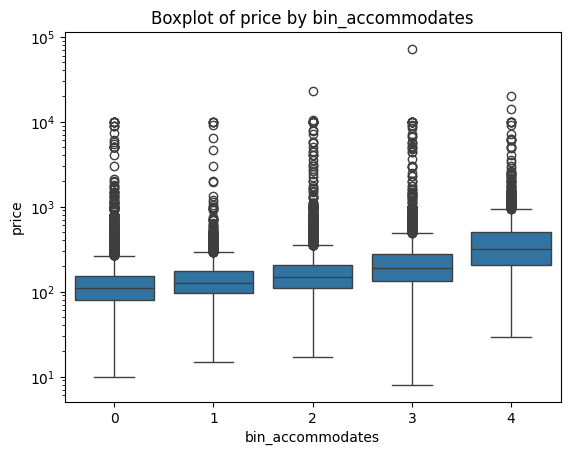

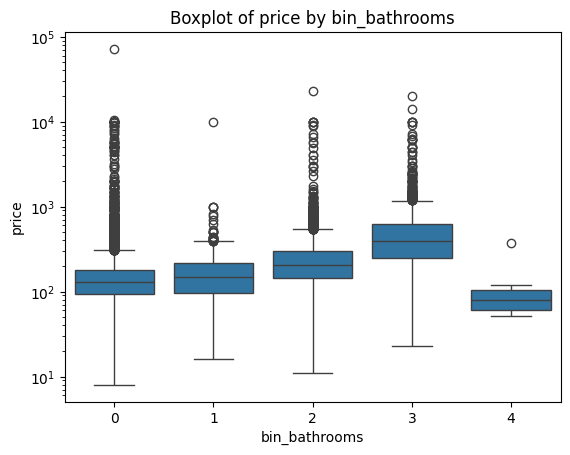

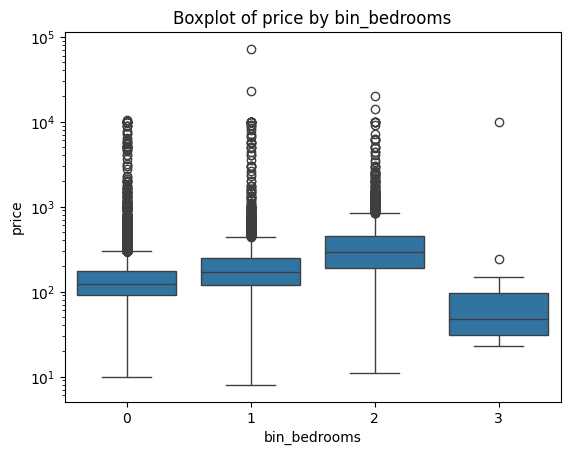

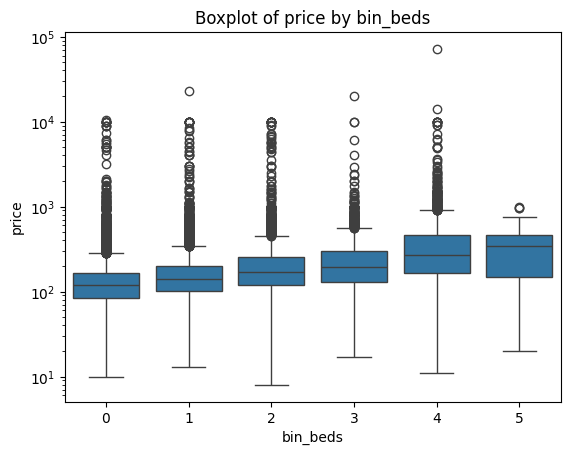

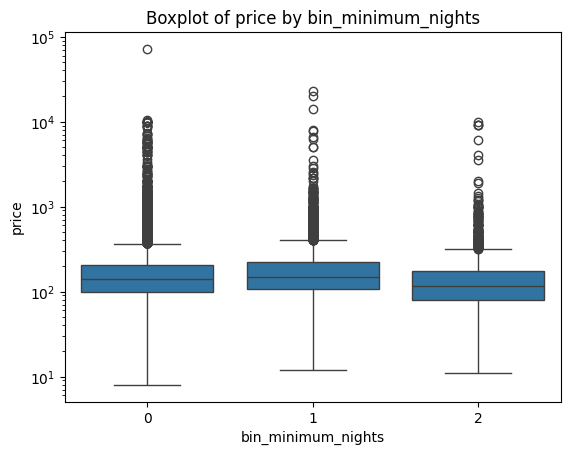

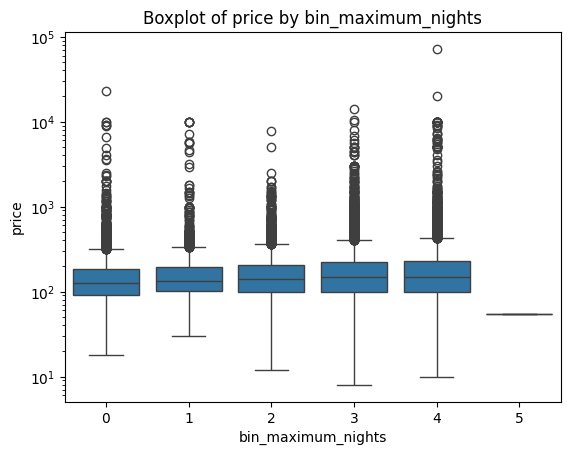

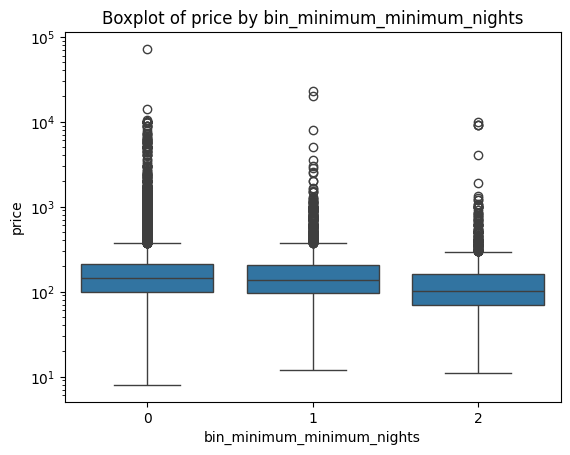

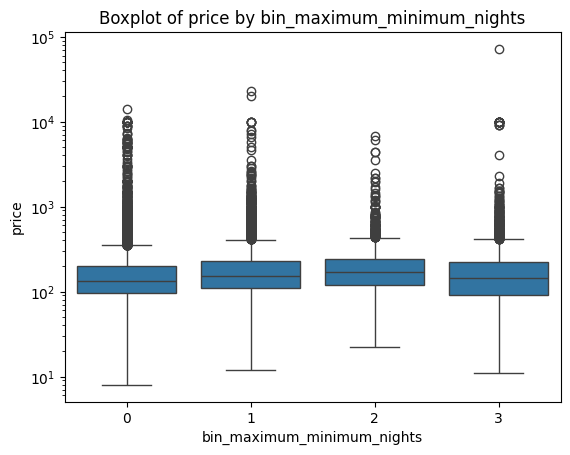

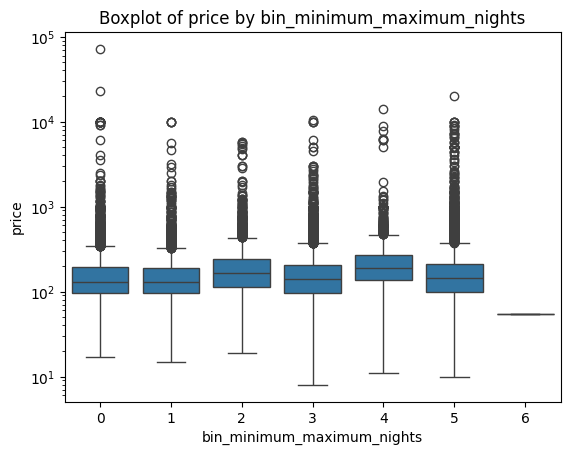

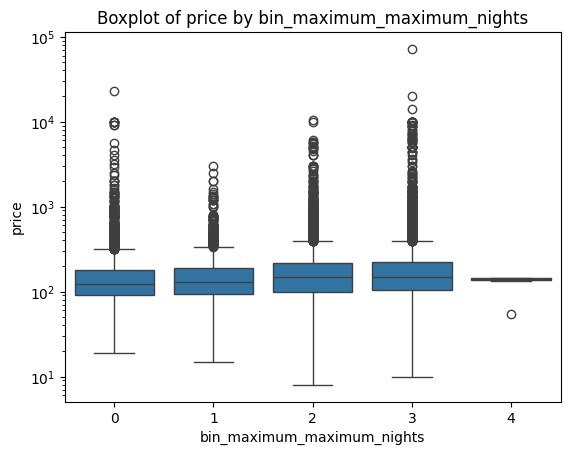

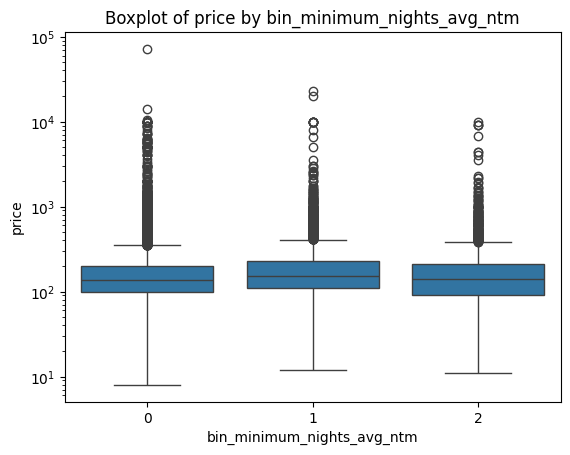

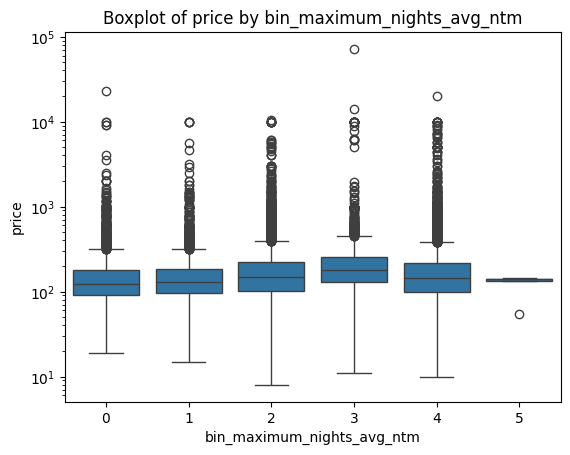

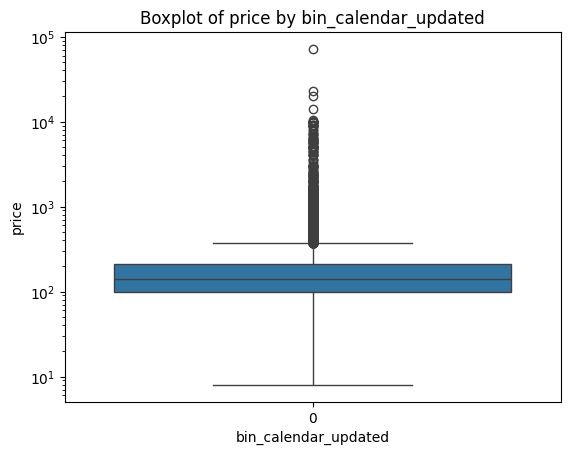

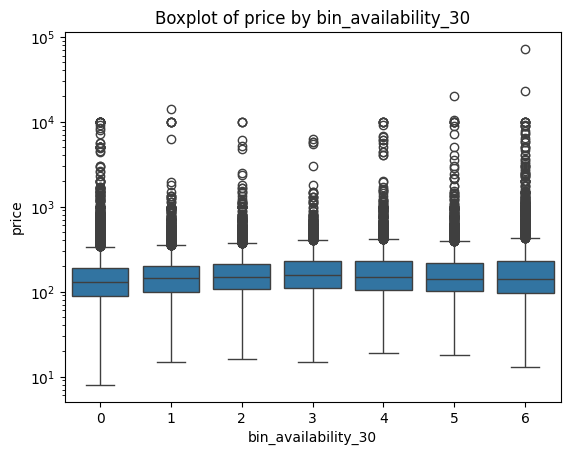

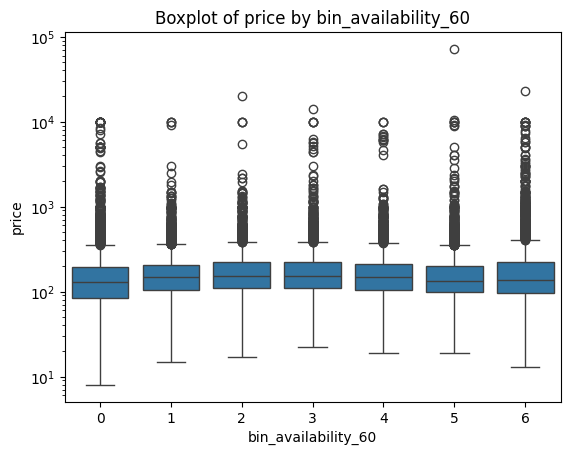

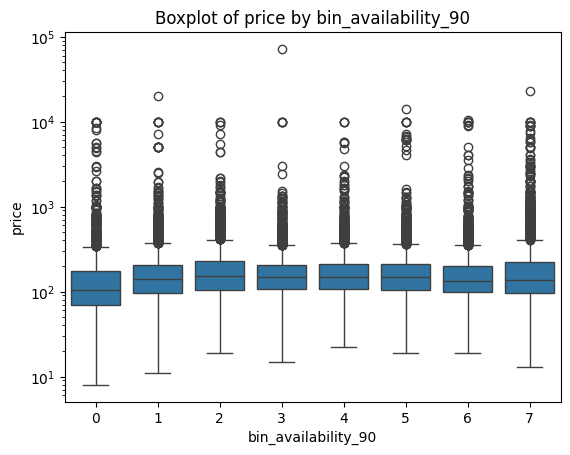

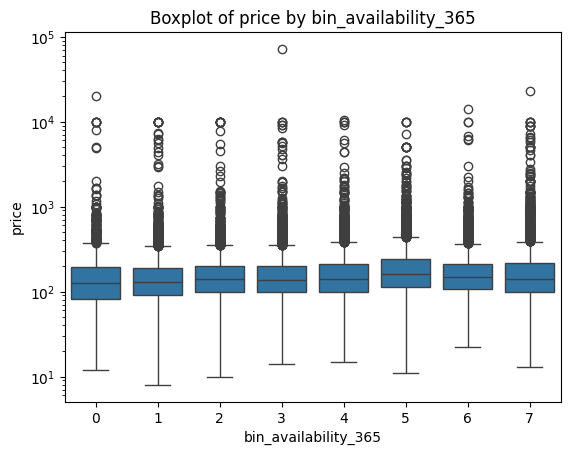

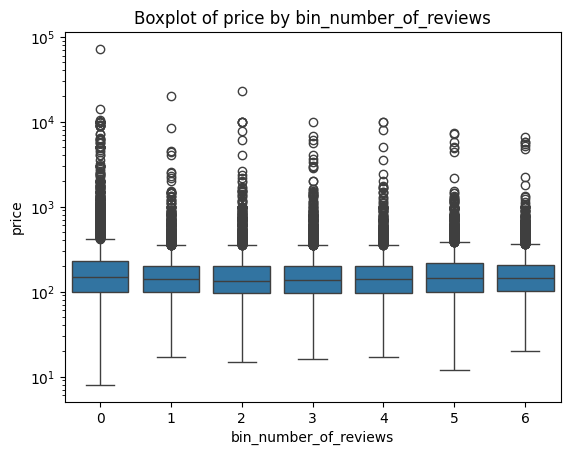

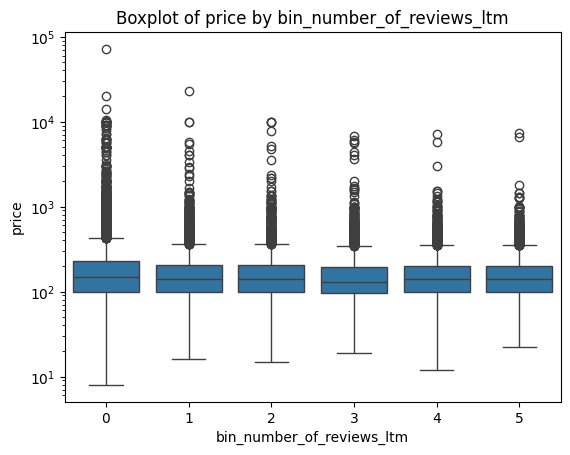

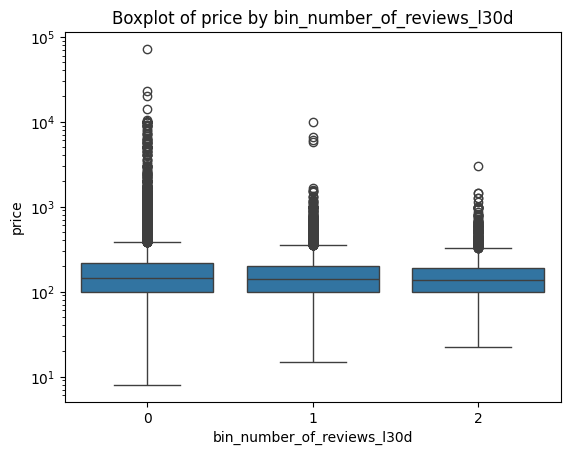

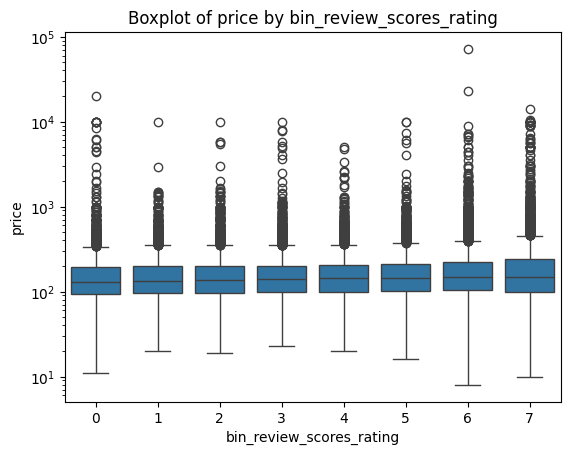

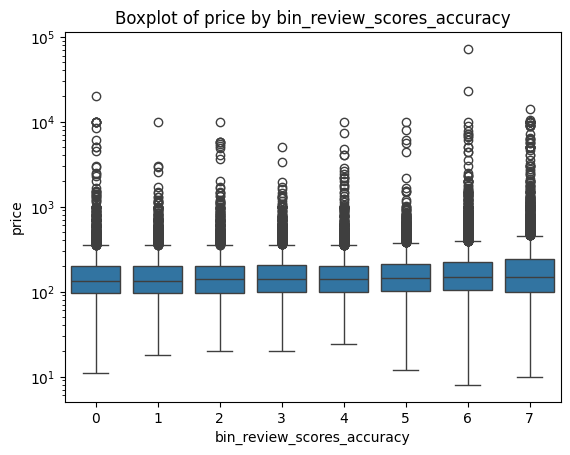

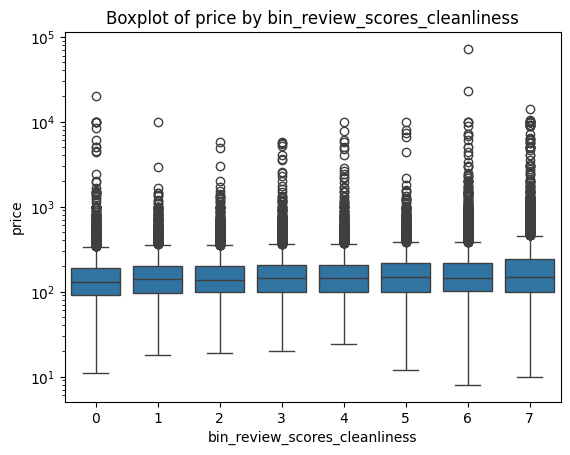

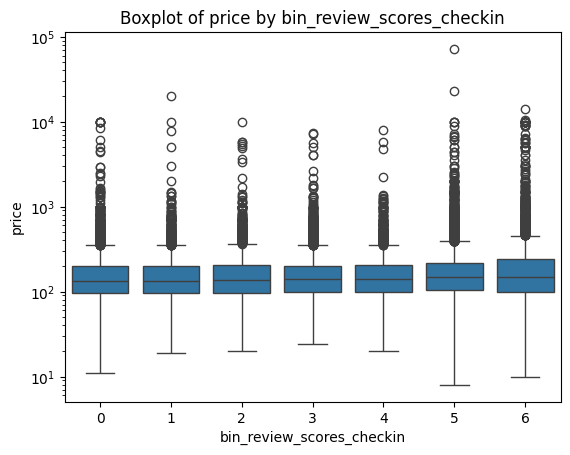

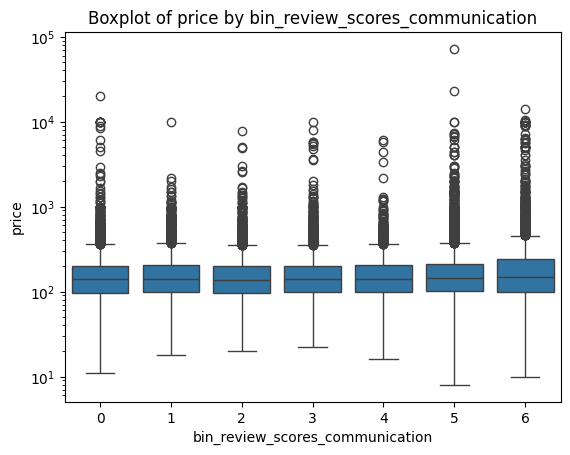

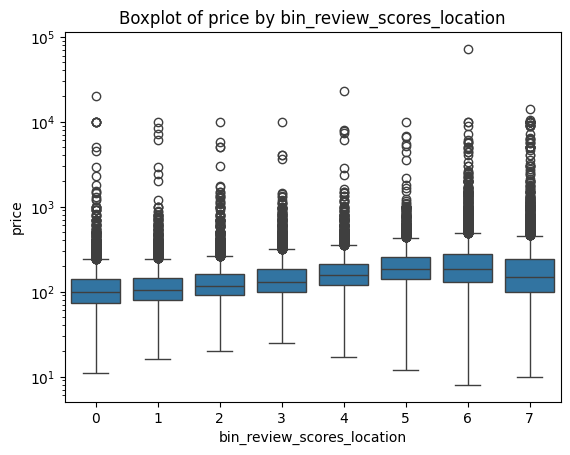

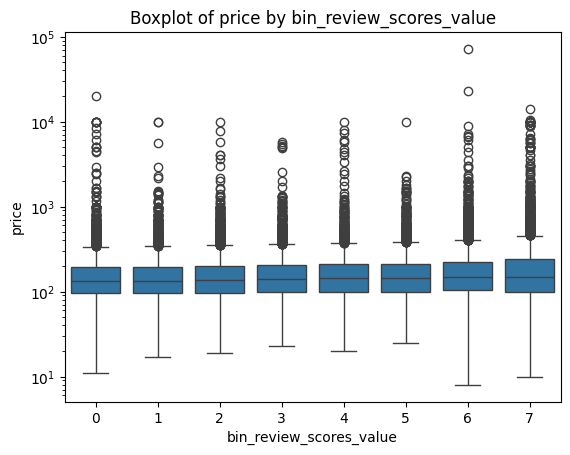

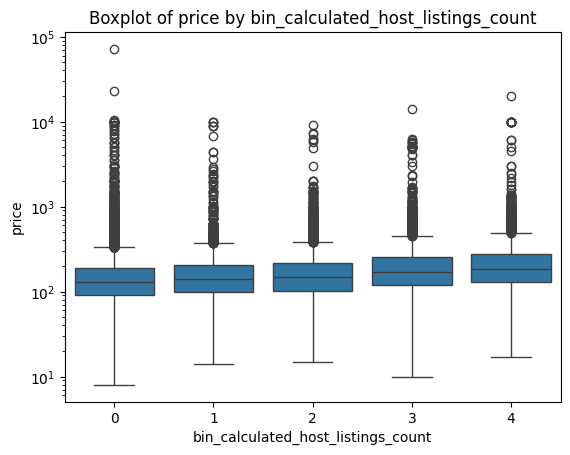

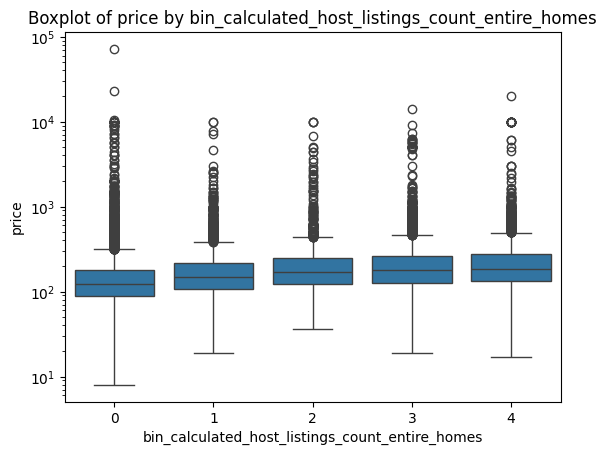

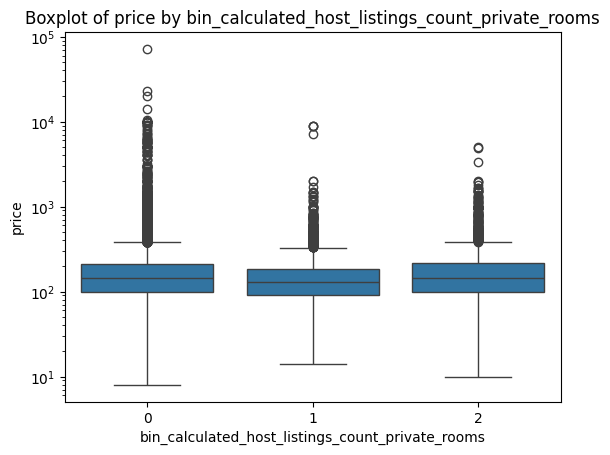

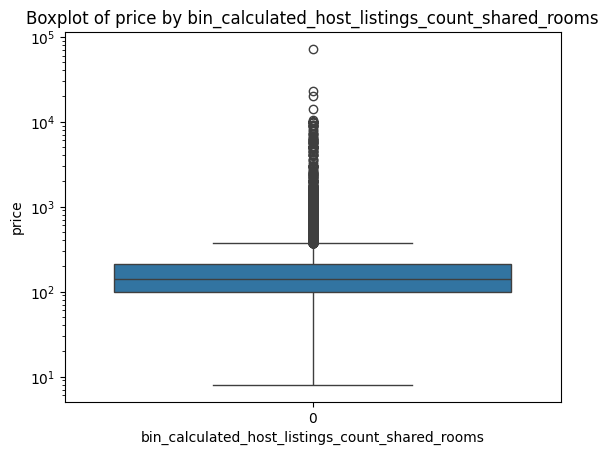

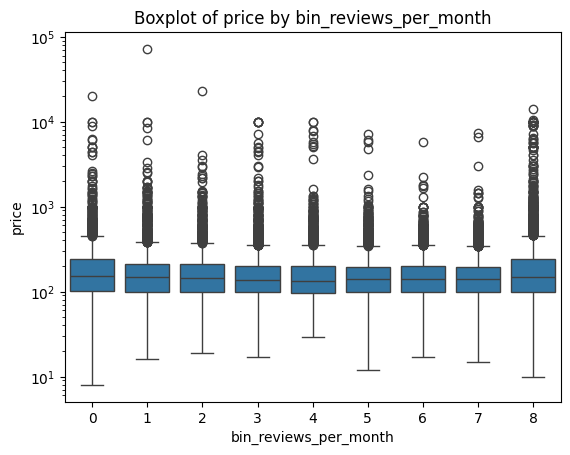

In [132]:
bin_listings_long = listings_long.copy()

def apply_cut_and_plot(bin_listings_long, target, bins=8):
    # Sélectionner les colonnes numériques sauf la colonne 'price'
    numeric_columns = bin_listings_long.select_dtypes(include=['float64', 'int64']).columns
    numeric_columns = numeric_columns.drop(target)

    for column in numeric_columns:
        # Appliquer pd.cut sur chaque colonne
        bin_listings_long[f'bin_{column}'] = pd.qcut(bin_listings_long[column], q=bins, duplicates='drop')

        # Replace NaN values with a separate category
        bin_listings_long[f'bin_{column}'] = bin_listings_long[f'bin_{column}'].cat.add_categories([-1]).fillna(-1)
        bin_listings_long[f'bin_{column}'] = bin_listings_long[f'bin_{column}'].cat.codes  # Get category codes

        # Tracer un boxplot
        sns.boxplot(x=f'bin_{column}', y=target, data=bin_listings_long)
        plt.yscale('log')
        plt.title(f'Boxplot of {target} by bin_{column}')
        plt.show()

# Utiliser la fonction sur ton DataFrame
apply_cut_and_plot(bin_listings_long, target='price')


#### Choice of columns being kept or not
- Columns being deleted
  - Redondant :
    - with neighbourhood_cleansed : 'neighbourhood'
    - with minimum_nights and maximum_nights : 'minimum_minimum_nights',
  'maximum_minimum_nights', 'minimum_maximum_nights',
  'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm'
    - with availability_365 : 'has_availability', 'availability_30', 'availability_60', 'availability_90'
    - with reviews_per_month : 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review', 'last_review'
    - with 'host_total_listings_count' : 'host_listings_count'

  - Irelevant :

    - 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'calendar_updated', 'calendar_last_scraped', 'license', 'instant_bookable'

  - Almost not correlated to price

    - 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'review_scores_rating', 'review_scores_accuracy','review_scores_cleanliness', 'review_scores_checkin',
  'review_scores_communication',
  'review_scores_value', 'reviews_per_month',  'availability_365', 'number_of_reviews'

- Column being replaced by numerical values :   
  
  - 'amenities' : counting the number of element in the list

- Columns being kept :

  - 'host_id', 'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'host_total_listings_count',  'review_scores_location'

In [133]:
df = listings_long

#Deleting info relative to host
df = df.drop(['host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms'], axis=1)

#Deleting some info relativ to min-max night
df = df.drop(['minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm'], axis=1)

#Deleting columns relativ to availability
df = df.drop(['calendar_updated', 'has_availability',
       'availability_30', 'availability_60', 'availability_90', 'availability_365', 'calendar_last_scraped'], axis=1)

#Deleting columns relativ to reviews
df = df.drop(['number_of_reviews_ltm', 'number_of_reviews_l30d',
       'first_review', 'last_review',
       'calculated_host_listings_count',
       'reviews_per_month', 'number_of_reviews',
       'review_scores_rating', 'review_scores_accuracy','review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_value'], axis=1)

#Deleting other columns
df = df.drop(['description','neighbourhood','license',
       'instant_bookable','listing_url','scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'neighbourhood_group_cleansed', 'picture_url'], axis=1)

#Replacing by numerical value
df['amenities_number'] = df['amenities'].apply(lambda x: len(x.split(',')) if isinstance(x, str) else 0)
df = df.drop(['amenities'], axis=1)


Columns that we have after deleting :

In [134]:
df.columns

Index(['id', 'host_id', 'host_total_listings_count', 'neighbourhood_cleansed',
       'latitude', 'longitude', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'price',
       'minimum_nights', 'maximum_nights', 'review_scores_location',
       'amenities_number'],
      dtype='object')

## Analisis of the link between price and the other data

In [135]:
df_analisis = df.copy()

### Numerical datas correlation with price

Calculating the correlation between the price and the other numerical values

Corelation matrix

price                        1.000000
bathrooms                    0.167722
accommodates                 0.149195
bedrooms                     0.148861
beds                         0.126583
host_total_listings_count    0.082339
maximum_nights               0.057505
review_scores_location       0.053704
latitude                     0.014637
host_id                      0.012013
id                          -0.004999
amenities_number            -0.006698
minimum_nights              -0.008404
longitude                   -0.011121
Name: price, dtype: float64


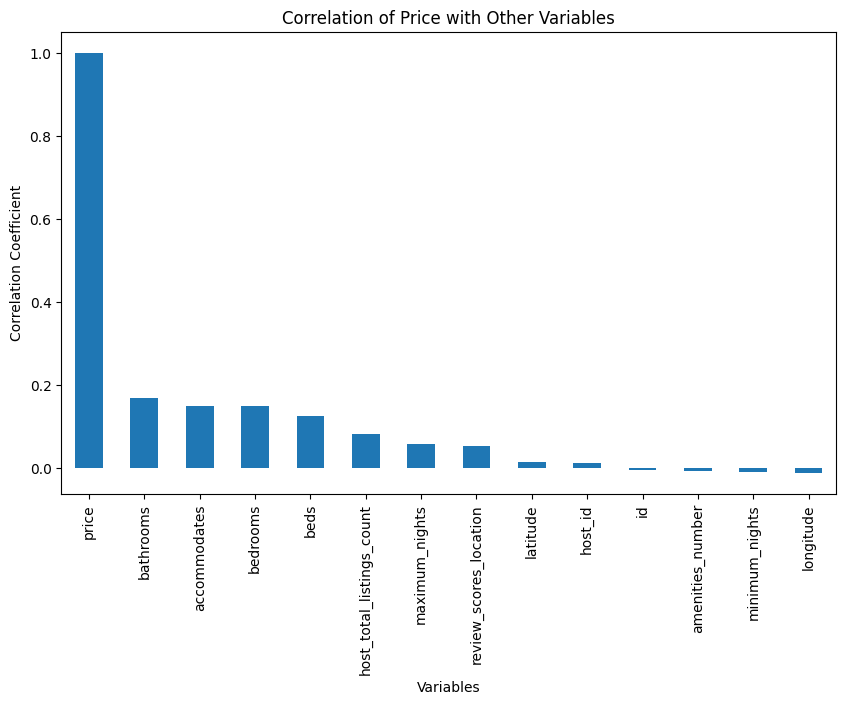

In [136]:
# Select the 'price' column and other relevant numerical columns
numerical_data = df_analisis.select_dtypes(include=np.number)
price_corr = numerical_data.corr()['price']

# Sort the correlations in descending order
price_corr = price_corr.sort_values(ascending=False)

# Print the correlations with the 'price' column
print(price_corr)

# Create a bar plot to visualize the correlations
plt.figure(figsize=(10, 6))
price_corr.plot(kind='bar')
plt.title('Correlation of Price with Other Variables')
plt.xlabel('Variables')
plt.ylabel('Correlation Coefficient')
plt.show()

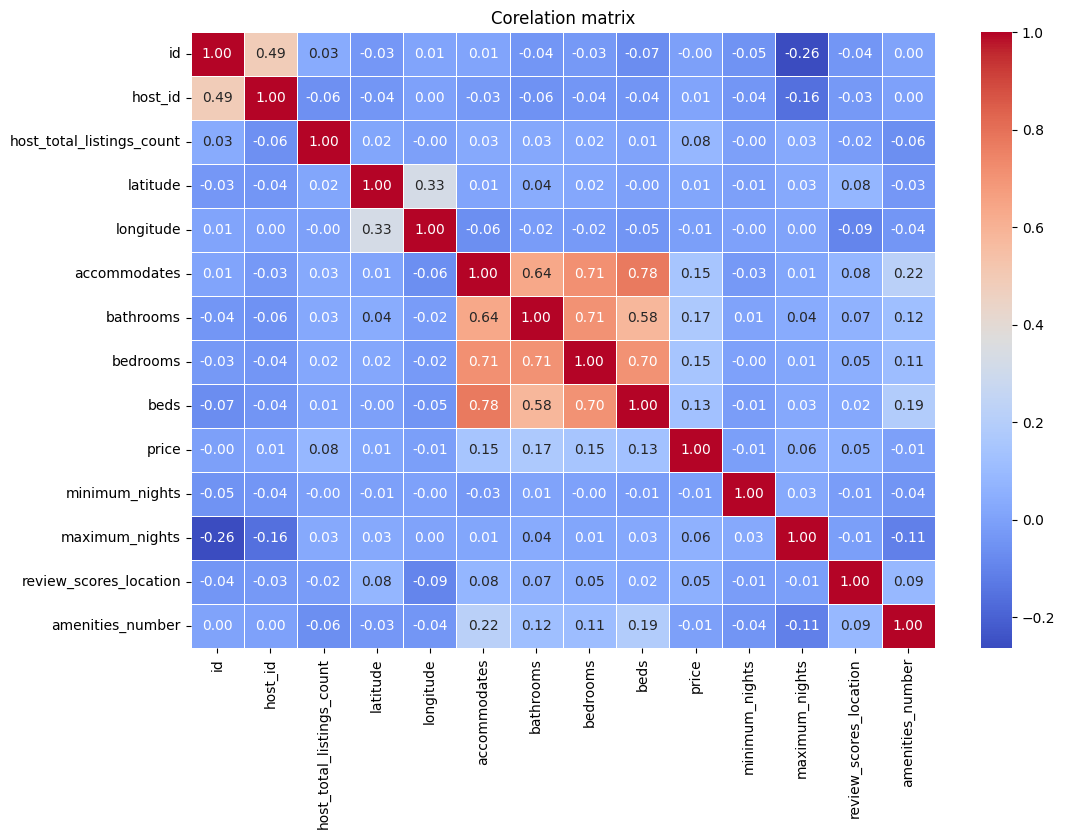

In [137]:
numeric_cols = df_analisis.select_dtypes(include='number')

corr_matrix = numeric_cols.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Corelation matrix')
plt.show()

We can see that price is not higly correlated to any numerical variable.

The best result we have is with accomodates, bathrooms, bedrooms and beds.

### Not numerical data

Creating a categorized price variable

In [138]:
# Binning price variable
bins = [0, 50, 100, 150, 200, 70000]
labels = ['<50', '50-100', '100-150', '150-200', '200+']
df_analisis['price_bins'] = pd.cut(df_analisis['price'], bins=bins, labels=labels, right=False)

#### Neighbourhood

We are first making a heatmap that shows how much elements there are for each price range in each neighbourhood.

We apply a log scale to have a result that is easy to understand.

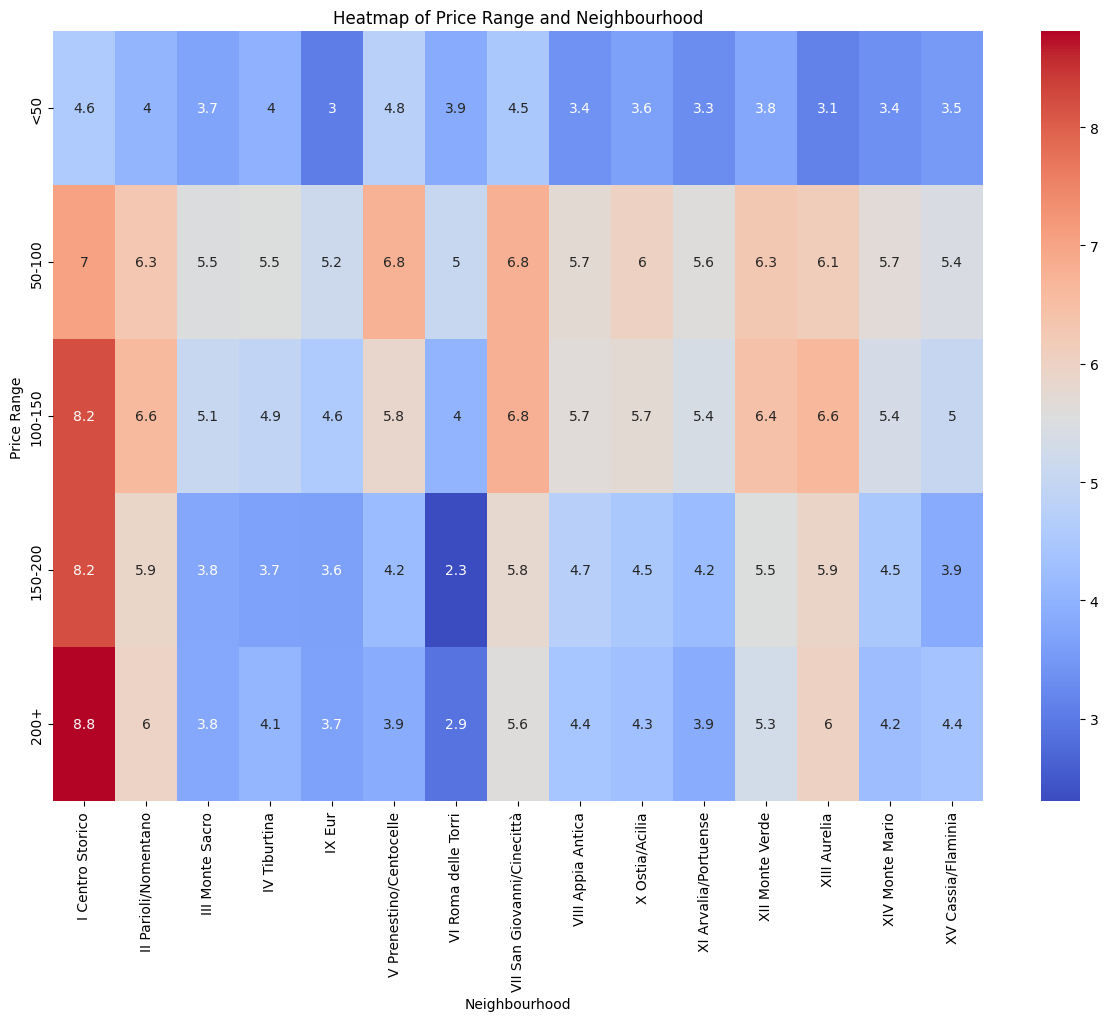

In [139]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a contingency table
contingency_table = pd.crosstab(df_analisis['price_bins'], df_analisis['neighbourhood_cleansed'])
log_corr_matrix = np.log1p(contingency_table)

# Create the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(log_corr_matrix, annot=True, cmap='coolwarm')
plt.title('Heatmap of Price Range and Neighbourhood')
plt.xlabel('Neighbourhood')
plt.ylabel('Price Range')
plt.show()


To better visualize the price repartition in each neighbourhood, we are making a graph that categorizes price in 5 bins and then shows for each neigbourhood the pourcentage of appartement from this neighbourhood in each categorie.


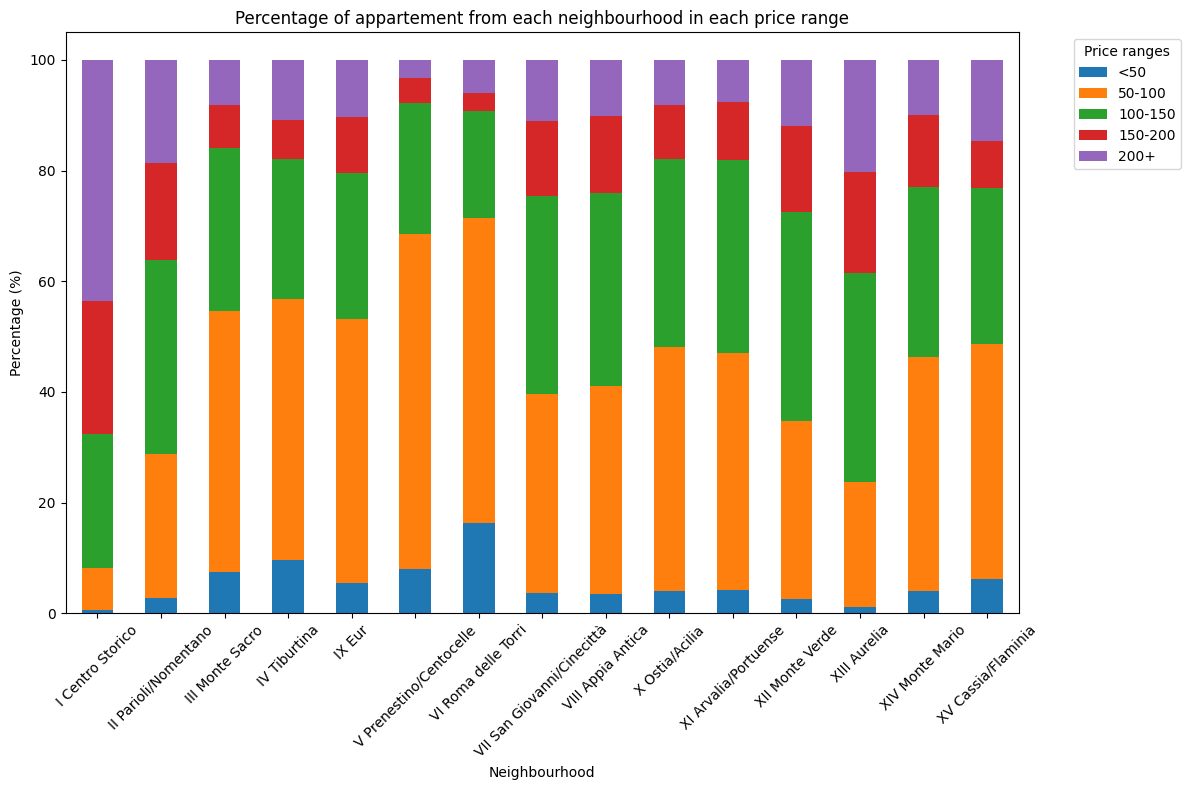

In [140]:
# Calculate % of appartement in each categorie for each neighbourhood
grouped = df_analisis.groupby(['neighbourhood_cleansed', 'price_bins'],observed=True).size().unstack(fill_value=0)
percentage = grouped.div(grouped.sum(axis=1), axis=0) * 100

percentage = percentage.fillna(0)  # Remplacer NaN par 0
percentage.plot(kind='bar', stacked=True, figsize=(12, 8))

plt.title('Percentage of appartement from each neighbourhood in each price range')
plt.xlabel('Neighbourhood')
plt.ylabel('Percentage (%)')
plt.legend(title='Price ranges', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


This graph shows us visualy that the price of the appartment is correlated to the neigbourhood.

We are going to do the same with property_type and room_type.

#### Property type

The same graph with property type is hard to read because of the number of categories, thus we will be grouping the smaller categories into one "other" categorie.

Version without grouping

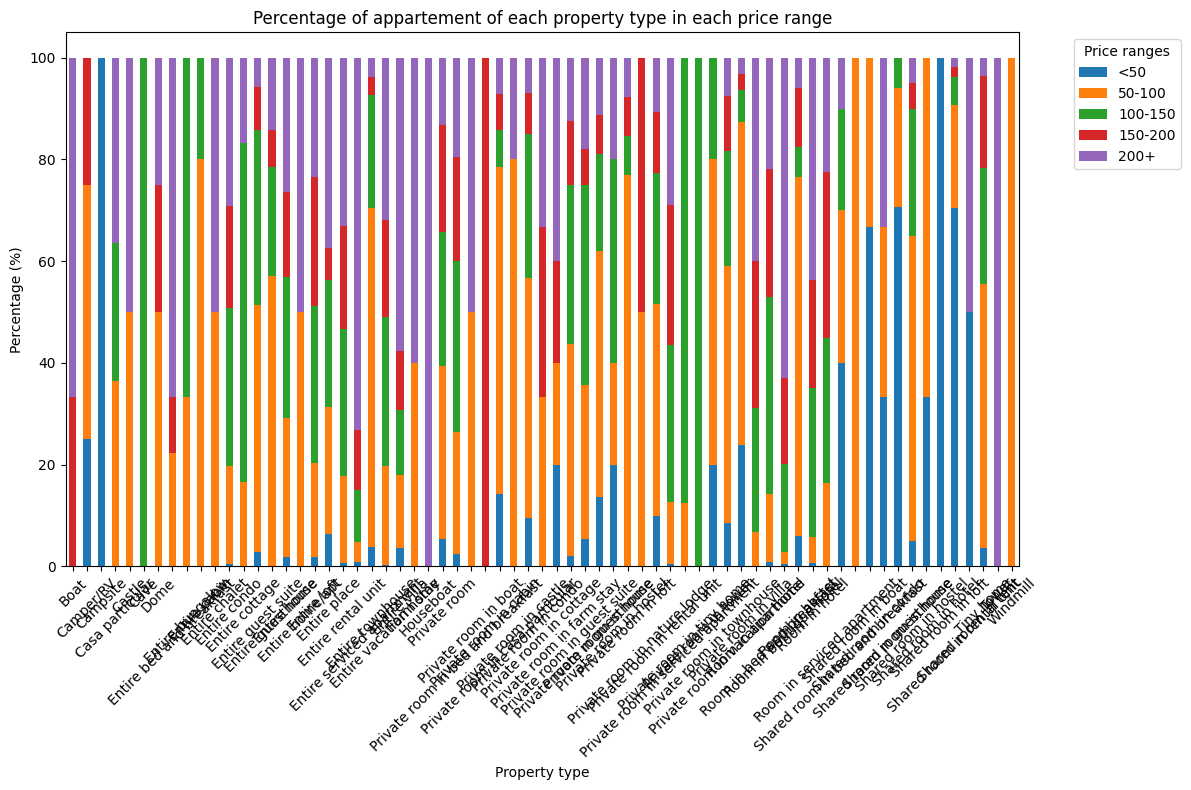

In [141]:
# Calculate % of appartement in each categorie for each property type
grouped = df_analisis.groupby(['property_type', 'price_bins'],observed=True).size().unstack(fill_value=0)
percentage = grouped.div(grouped.sum(axis=1), axis=0) * 100

# Show graph
percentage = percentage.fillna(0)  # Remplacer NaN par 0
percentage.plot(kind='bar', stacked=True, figsize=(12, 8))

plt.title('Percentage of appartement of each property type in each price range')
plt.xlabel('Property type')
plt.ylabel('Percentage (%)')
plt.legend(title='Price ranges', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Grouping element in categorie with less then 50 elements into 'Other'

In [142]:
# Count the number of lignes with each possible value for property type
property_type_counts = df_analisis['property_type'].value_counts()

# Create a new dataframe where all elements in a categorie with less then 50 elements go into a new categorie 'other'
df_analisis['property_type_grouped'] = df_analisis['property_type']
for property_type in property_type_counts.index:
  if property_type_counts[property_type] < 50:
    df_analisis.loc[df['property_type'] == property_type, 'property_type_grouped'] = 'Other'

# Print the number of lignes with each possible value for the new categorie
property_type_grouped_counts = df_analisis['property_type_grouped'].value_counts()
#print(property_type_grouped_counts)

#Create a dataframe for the new categorie
df_property_type_grouped = df_analisis[['property_type_grouped','price_bins']]

Version with only catégories with more then 50 elements.

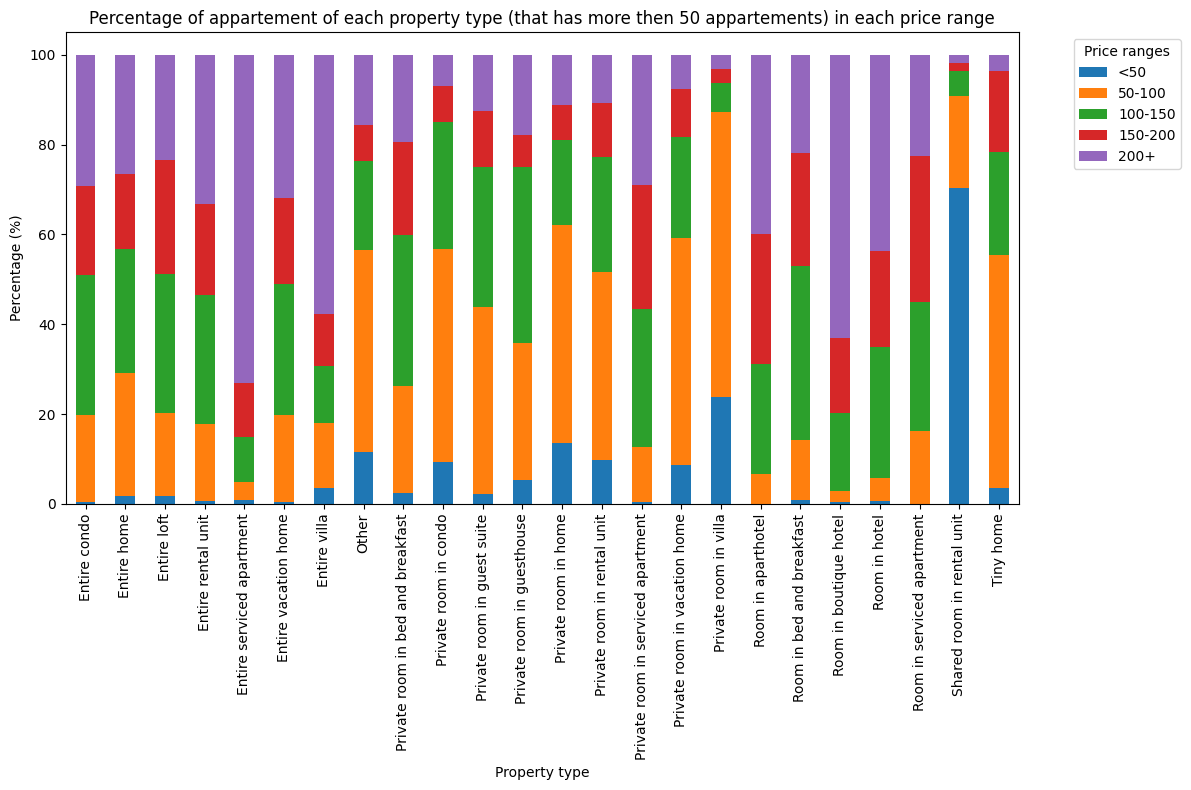

In [102]:
# Calculate % of appartement in each categorie for each property type
grouped = df_property_type_grouped.groupby(['property_type_grouped', 'price_bins'],observed=True).size().unstack(fill_value=0)
percentage = grouped.div(grouped.sum(axis=1), axis=0) * 100

percentage = percentage.fillna(0)
percentage.plot(kind='bar', stacked=True, figsize=(12, 8))

plt.title('Percentage of appartement of each property type (that has more then 50 appartements) in each price range')
plt.xlabel('Property type')
plt.ylabel('Percentage (%)')
plt.legend(title='Price ranges', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

#### Room type

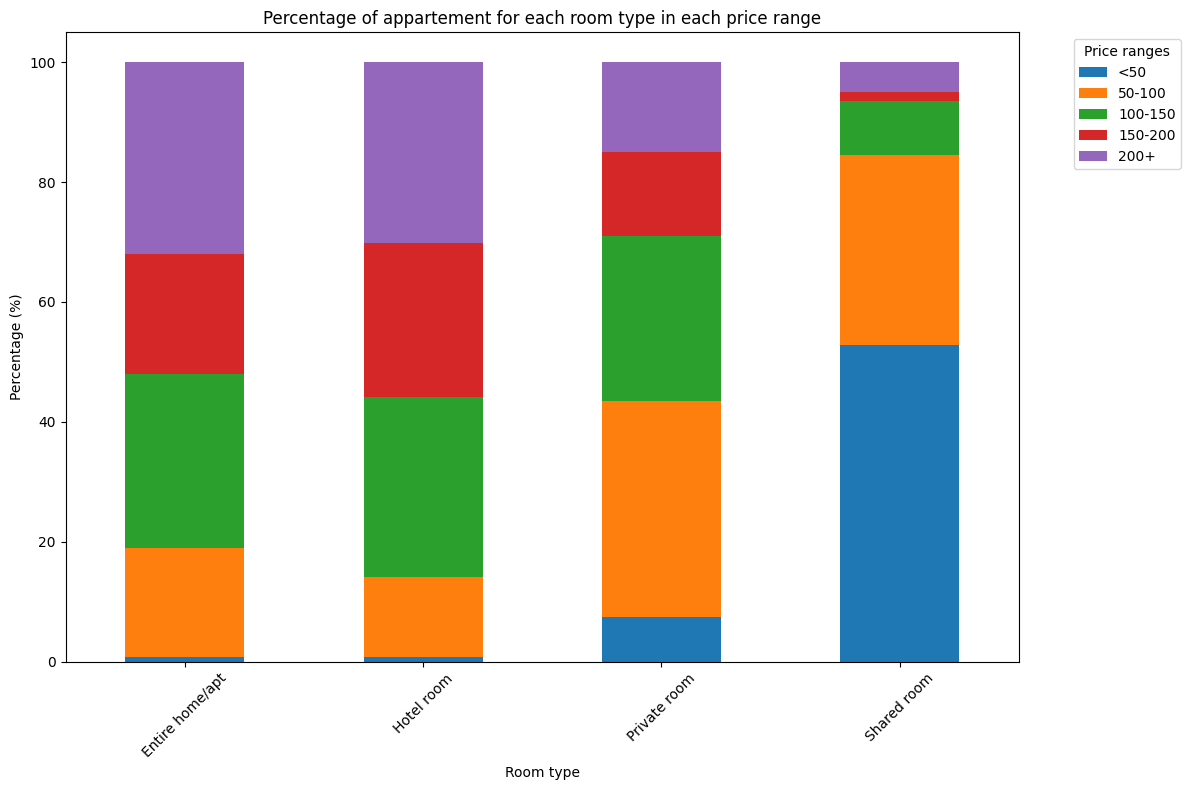

In [103]:
# Calculate % of appartement in each categorie for each room type
grouped = df_analisis.groupby(['room_type', 'price_bins'],observed=True).size().unstack(fill_value=0)
percentage = grouped.div(grouped.sum(axis=1), axis=0) * 100

percentage = percentage.fillna(0)
percentage.plot(kind='bar', stacked=True, figsize=(12, 8))

plt.title('Percentage of appartement for each room type in each price range')
plt.xlabel('Room type')
plt.ylabel('Percentage (%)')
plt.legend(title='Price ranges', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The type of room and type of property also seem correlated with price and will be useful to train our model.

##Valores Faltantes

### NaNs



Percentaje de NaNs

In [104]:
filas_totales = df.shape[0]
print(df.isna().sum() / filas_totales * 100)

id                            0.000000
host_id                       0.000000
host_total_listings_count     0.000000
neighbourhood_cleansed        0.000000
latitude                      0.000000
longitude                     0.000000
property_type                 0.000000
room_type                     0.000000
accommodates                  0.000000
bathrooms                    11.044890
bathrooms_text                0.135052
bedrooms                      2.771498
beds                         11.226916
price                        11.053698
minimum_nights                0.000000
maximum_nights                0.000000
review_scores_location       14.920290
amenities_number              0.000000
dtype: float64


### Otros tipos de valores faltantes

#### Caracter raro
We are checking the data set for - that would indicate missing values

In [105]:
tienen_caracter_raro = df.astype("str").eq("-").any()
print("Columnas con caracteres raros:")
tienen_caracter_raro

Columnas con caracteres raros:


,0
id,False
host_id,False
host_total_listings_count,False
neighbourhood_cleansed,False
latitude,False
longitude,False
property_type,False
room_type,False
accommodates,False
bathrooms,False


#### Valores imposibles
We are checking for values >0

Columns with numerical values :

In [106]:
numeric_columns = df.select_dtypes(include=np.number).columns.tolist()
print(numeric_columns)

['id', 'host_id', 'host_total_listings_count', 'latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'minimum_nights', 'maximum_nights', 'review_scores_location', 'amenities_number']


Checking if there exists values < 0

In [107]:
(df[numeric_columns] < 0).any().to_frame("Menor que 0 ?")

,Menor que 0 ?
id,False
host_id,False
host_total_listings_count,False
latitude,False
longitude,False
accommodates,False
bathrooms,False
bedrooms,False
beds,False
price,False


As we can see, we don't have below zero values.

#### Duplicados

Checking for duplicates

In [108]:
df[df.duplicated(keep=False)]

,id,host_id,host_total_listings_count,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,price,minimum_nights,maximum_nights,review_scores_location,amenities_number


We don't have any duplicates.

### Taking care of NaN values

In [109]:
filas_totales = df.shape[0]
print(df.isna().sum() / filas_totales * 100)

id                            0.000000
host_id                       0.000000
host_total_listings_count     0.000000
neighbourhood_cleansed        0.000000
latitude                      0.000000
longitude                     0.000000
property_type                 0.000000
room_type                     0.000000
accommodates                  0.000000
bathrooms                    11.044890
bathrooms_text                0.135052
bedrooms                      2.771498
beds                         11.226916
price                        11.053698
minimum_nights                0.000000
maximum_nights                0.000000
review_scores_location       14.920290
amenities_number              0.000000
dtype: float64



Column were NaN are being **replaced by average**
- Review_scores_location

Column were NaN are being **replaced thanks to an other column** :
- Bathrooms with Bathrooms_text

Columns were NaNs are **replaced with MICE** (Multivariate Imputation by Chained Equations)
- Accomodates : number of people that can sleep in the appartment
- Bathroom
- Bedroom
- Beds

  -> These columns are being replaced with MICE because they are all linked with one an other thus the values we will find are going to be good.

Columns were NaNs **won't be replaced**
- price

  -> Imputing the NaNs in the price columns would be creating a bias in our model as estimating the price is the point of our model. We will have to erase the 10% of the lines were we don't have the price in order to avoid this biais.

#### Replacing by average

In [110]:
df['review_scores_location'] = df['review_scores_location'].fillna(df['review_scores_location'].mean())

#### Replacing thanks to an other column

In [111]:
print(df['bathrooms_text'].unique())

['1.5 baths' '1 bath' '2 baths' '1 private bath' '3 baths' '5 baths'
 '6.5 baths' '4 baths' '2.5 baths' '1 shared bath' nan '3 shared baths'
 '2 shared baths' '0 shared baths' '1.5 shared baths' 'Half-bath'
 '4.5 baths' '0 baths' '3.5 baths' '5.5 baths' '2.5 shared baths'
 '12.5 baths' '6 baths' '5 shared baths' '7 baths' '6 shared baths'
 'Shared half-bath' '8 baths' '7.5 baths' '12 baths' '9.5 baths'
 'Private half-bath' '21.5 baths' '4 shared baths' '10 shared baths'
 '9 baths' '10 baths' '5.5 shared baths' '24 baths']


Creating a bathroom_number column with the data of bathroom text in a numerical form

In [112]:
import re

#Fonction to keep only the numerical value in bathrooms_text
def extract_bathroom_number(text):
  """
  Extracts the numerical part of a bathroom description string.

  Args:
    text: The bathroom description string (e.g., "1.5 baths", "1 bath").

  Returns:
    The numerical part of the description, or None if no number is found.
  """
  if not isinstance(text, str):
    return None

  match = re.search(r"(\d+(\.\d+)?)", text)
  if match:
    return float(match.group(1))
  else:
    return None

# Apply the function to the 'bathrooms_text' column
df['bathroom_number'] = df['bathrooms_text'].apply(extract_bathroom_number)

# Replace bathroom_number with 0.5 if bathroom text contains 'Half-bath', 'Shared half-bath', or 'Private half-bath'
df.loc[(df['bathrooms_text'].str.contains('Half-bath', na=False)) |
       (df['bathrooms_text'].str.contains('Shared half-bath', na=False)) |
       (df['bathrooms_text'].str.contains('Private half-bath', na=False)), 'bathroom_number'] = 0.5

Remplace the NaNs of bathrooms by the value in bathroom_number

In [113]:
df['bathrooms'] = df['bathrooms'].fillna(df['bathroom_number'])

Deleting bathrooms_text now that we don't need it anymore

In [114]:
df.drop(['bathrooms_text','bathroom_number'], axis="columns", inplace=True)

#### Replacing with Multivariate Imputation by Chained Equations.

In [115]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

columns_to_imput = ['accommodates', 'bathrooms', 'bedrooms', 'beds']
imput = IterativeImputer(max_iter=10, random_state=0)
df[columns_to_imput] = imput.fit_transform(df[columns_to_imput])

#### Deleting lines with NaNs in the price column

In [116]:
df.dropna(subset=['price'], inplace=True)

#### Checking if we don't have any NaNs anymore.

In [117]:
filas_totales = df.shape[0]
print(df.isna().sum() / filas_totales * 100)

id                           0.0
host_id                      0.0
host_total_listings_count    0.0
neighbourhood_cleansed       0.0
latitude                     0.0
longitude                    0.0
property_type                0.0
room_type                    0.0
accommodates                 0.0
bathrooms                    0.0
bedrooms                     0.0
beds                         0.0
price                        0.0
minimum_nights               0.0
maximum_nights               0.0
review_scores_location       0.0
amenities_number             0.0
dtype: float64


## Analisis valores atipicos (outliers)

### Analisis univariado


#### Drawing Boxplots to get a gobal idea of data repartition

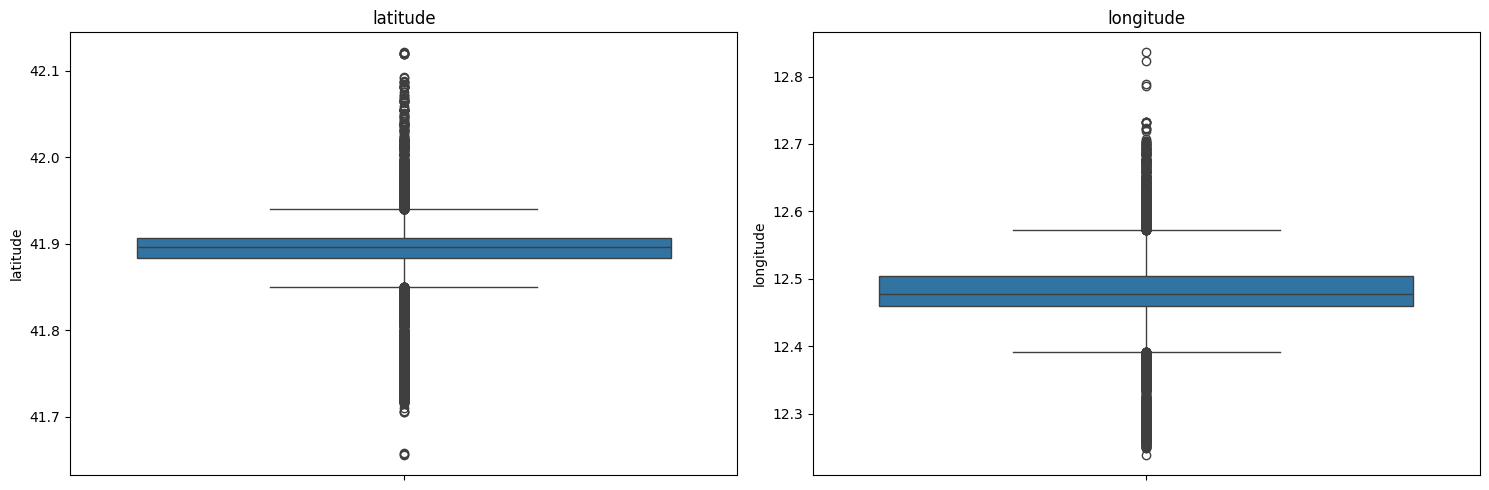

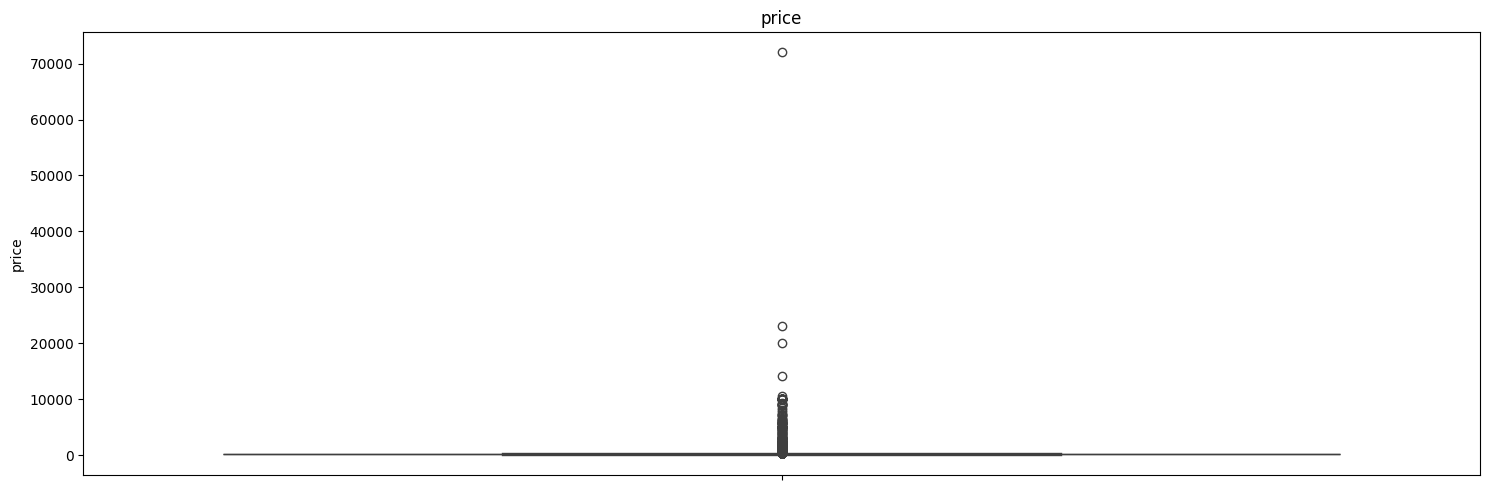

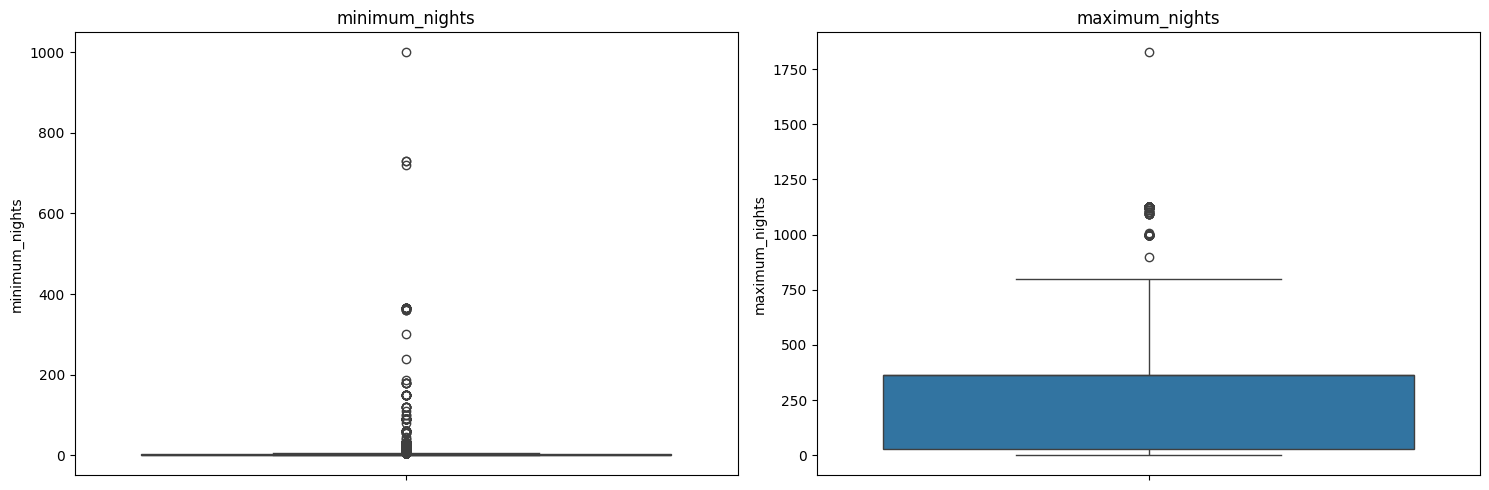

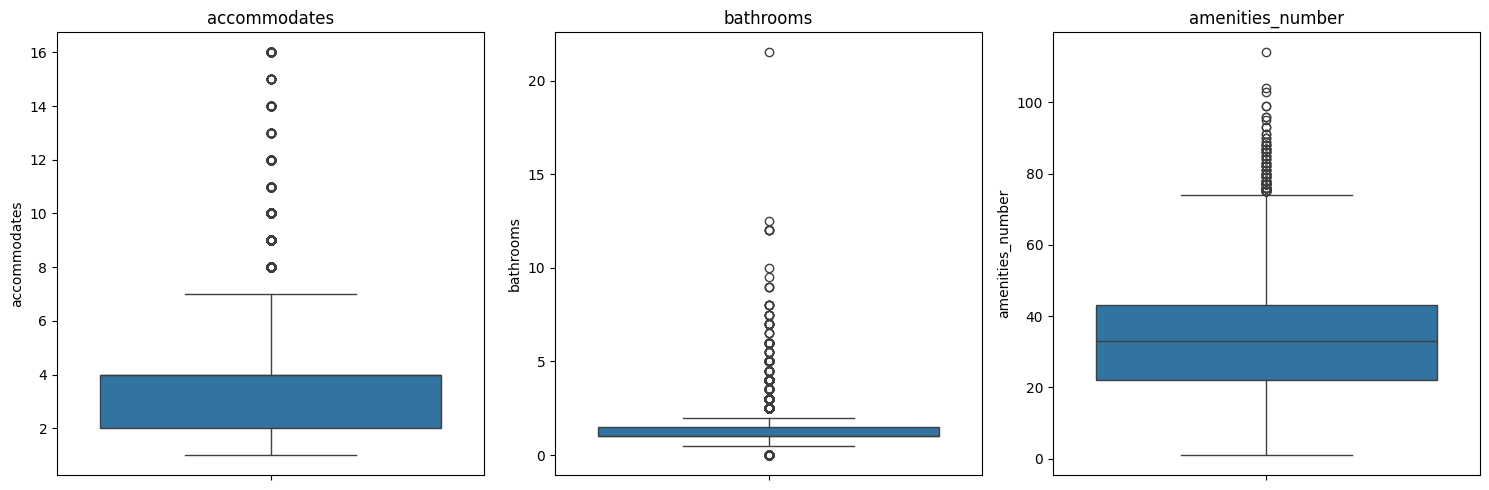

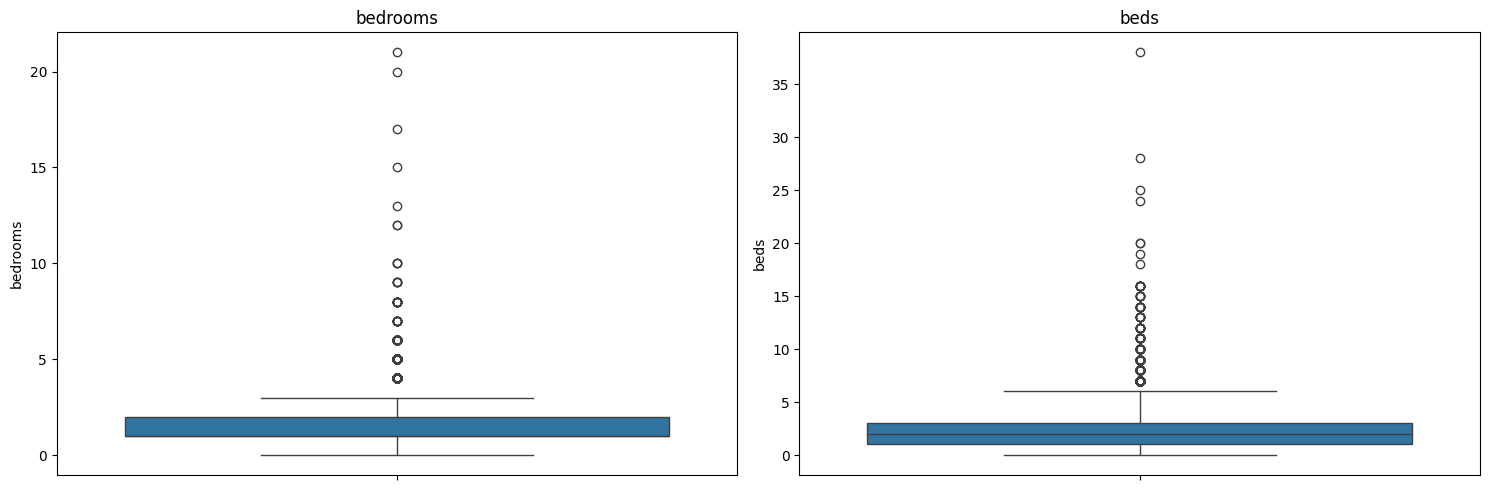

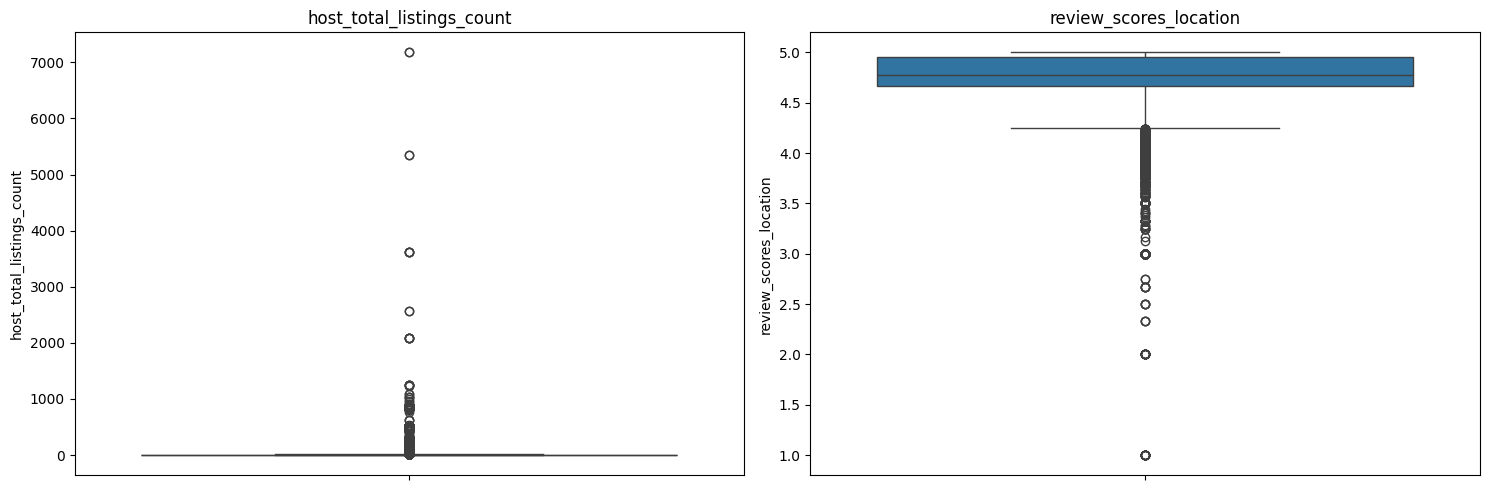

In [118]:
# Grafico de cajas
groups = [
    ['latitude', 'longitude'],
    ['price'],
    ['minimum_nights', 'maximum_nights'],
    ['accommodates', 'bathrooms','amenities_number'],
    ['bedrooms', 'beds'],
    ['host_total_listings_count','review_scores_location']
]

for group in groups:
    plt.figure(figsize=(15, 5))
    for i, col in enumerate(group, 1):
        plt.subplot(1, len(group), i)
        sns.boxplot(y=df[col])
        plt.title(col)
    plt.tight_layout()
    plt.show()

We can see with the graphs that most variable have a lot of values far from average.

We are going to calculate the percentage of outliers with IQR :  

In [41]:
def detect_outliers_iqr(df):
    Q1 = np.percentile(df, 25)
    Q3 = np.percentile(df, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = np.where((df < lower_bound) | (df > upper_bound))
    return outliers

In [42]:
outliers = pd.DataFrame(columns=['variable', 'cant outliers', 'porcentaje'])

for col in df.select_dtypes(include='number').columns:
    outliers_idx = detect_outliers_iqr(df[col])[0]
    if len(outliers_idx) > 0:
        outliers = pd.concat([outliers, pd.DataFrame({'variable': [col], 'cant outliers': [len(outliers_idx)], 'porcentaje': [len(outliers_idx) / df.shape[0] * 100]})], ignore_index=True)

outliers.sort_values('porcentaje', ascending=False)

<ipython-input-42-58a3a4138504>:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  outliers = pd.concat([outliers, pd.DataFrame({'variable': [col], 'cant outliers': [len(outliers_idx)], 'porcentaje': [len(outliers_idx) / df.shape[0] * 100]})], ignore_index=True)


,variable,cant outliers,porcentaje
9,maximum_nights,6563,21.662926
0,host_total_listings_count,3812,12.582519
1,latitude,2827,9.331265
7,price,2300,7.591761
2,longitude,1792,5.914972
10,review_scores_location,1561,5.152495
4,bathrooms,1519,5.013863
3,accommodates,1446,4.772907
5,bedrooms,782,2.581199
8,minimum_nights,727,2.399657


We can see that some variables such as maximums_nights or the coordinates have many outliers.
We are also going to continue our analisis by looking at the percentage of outliers using modified z-score.

#### Z-Score Modificado

Calculating the percentage of outliers with Z-score modificado

In [43]:
# Function to calculate the modified Z-score for a given column
def modified_z_score(column):
    # Calculate the median of the column
    median = np.median(column)
    # Calculate the MAD (Median Absolute Deviation)
    mad = np.median(np.abs(column - median))
    # Compute the modified Z-score
    z_mod = 0.6745 * (column - median) / mad
    return z_mod

# Function to calculate the percentage of outliers in each numeric column of a DataFrame
def calculate_outliers_percentage(df):
    outliers_percentage = {}

    for col in df.select_dtypes(include=[np.number]):
        z_scores = modified_z_score(df[col].dropna())
        outliers = np.abs(z_scores) > 3.5
        outliers_percentage[col] = np.sum(outliers) / len(df[col].dropna()) * 100

    return outliers_percentage

outliers_percent = calculate_outliers_percentage(df)

# Display the percentage of outliers for each column
for col, percent in outliers_percent.items():
    print(f"{col}: {percent:.2f}% of outliers")



id: 0.00% of outliers
host_id: 0.00% of outliers
host_total_listings_count: 18.46% of outliers
latitude: 7.03% of outliers
longitude: 4.50% of outliers
accommodates: 0.28% of outliers
bathrooms: 25.81% of outliers
bedrooms: 37.99% of outliers
beds: 0.82% of outliers
price: 6.17% of outliers
minimum_nights: 1.64% of outliers
maximum_nights: 0.00% of outliers
review_scores_location: 3.36% of outliers
amenities_number: 0.04% of outliers


Using the modificated Z-score we have an even bigger amount of outliers in the variables bathrooms and bedrooms.

Let's look at what values of bedrooms and bathrooms are considered outliers

In [44]:
# Function to identify outliers in a DataFrame column using modified Z-score
def identify_outliers(df, column_name):
    z_scores = modified_z_score(df[column_name])
    outliers = df[np.abs(z_scores) > 3.5]
    return outliers

# Identify outliers in 'bathrooms' and 'bedrooms'
outliers_bathrooms = identify_outliers(df, 'bathrooms')
outliers_bedrooms = identify_outliers(df, 'bedrooms')

# Display the different values of outliers in 'bathrooms'
print("Different values of outliers in 'bathrooms':")
print(outliers_bathrooms['bathrooms'].unique())

# Display the different values of outliers in 'bedrooms'
print("\nDifferent values of outliers in 'bedrooms':")
print(outliers_bedrooms['bedrooms'].unique())


Different values of outliers in 'bathrooms':
[ 1.5         2.          3.          5.          6.5         4.
  2.5         0.94628503  0.          0.5         4.5         6.
  3.5         5.5        12.5         7.          8.          7.5
 12.          9.5        21.5        10.          9.          1.01759933]

Different values of outliers in 'bedrooms':
[ 2.          3.          0.          4.          5.          6.
  0.93908751 12.         15.          7.         10.          8.
  9.         21.         13.          1.51140735  1.1588328   1.22524743
 17.         20.          0.82921486  1.35807669  1.29166206  0.33370787]


It seems that all values different then 1 are considered as outliers

In [45]:
percentage_bathrooms_1 = (df['bathrooms'] == 1).mean() * 100
percentage_bedrooms_1 = (df['bedrooms'] == 1).mean() * 100

print(f"Percentage of lines where bathrooms = 1 : {percentage_bathrooms_1:.2f}%")
print(f"Percentage of lines where bedrooms = 1  : {percentage_bedrooms_1:.2f}%")


Percentage of lines where bathrooms = 1 : 74.19%
Percentage of lines where bedrooms = 1  : 62.01%


Because of the large number of appartment with only one bathroom/bedroom with the modificated z-score all values other then 1 are considered outliers.

Deleting those "outliers" would be a considerable data loss and if the only possible value is one it does not participate in our model.
We could thus use the quartil method to deal with outliers for these categories and modificated z-score to deal with outliers for the other categories.

The variable host_total_listings_count will also taken care of with IQR because of the important amount of outliers.

### Analisis multivariado

#### Distance de mahalanobis

In [46]:
columns_mahalanobis = ['latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'minimum_nights', 'maximum_nights', 'amenities_number']
df_mahalanobis = df[columns_mahalanobis]

# Calculate the covariance matrix of the numeric columns
cov_matrix = np.cov(df_mahalanobis.values, rowvar=False)

# Calculate the inverse of the covariance matrix
inv_cov_matrix = np.linalg.inv(cov_matrix)

# Calculate the mean of the numeric columns
mean_values = df_mahalanobis.mean(axis=0).values

# Function to calculate Mahalanobis distance for a given row
def mahalanobis_distance(row, mean, inv_cov_matrix):
    diff = row - mean
    return np.sqrt(np.dot(np.dot(diff, inv_cov_matrix), diff.T))

# Appling the function to each row and directly filter rows with mahalanobis > 7
mahalanobis_greater_than_7 = df_mahalanobis.apply(
    lambda row: mahalanobis_distance(row.values, mean_values, inv_cov_matrix) > 7,
    axis=1
)

# Number of lines where Mahalanobis > 7
num_lines_mahalanobis_sup_7 = mahalanobis_greater_than_7.sum()

# Percentage of lines where Mahalanobis > 7
percentage_mahalanobis_sup_7 = (num_lines_mahalanobis_sup_7 / len(df_mahalanobis)) * 100

print(f"\nPercentage of lines with Mahalanobis > 7: {percentage_mahalanobis_sup_7:.2f}%")



Percentage of lines with Mahalanobis > 7: 1.43%


Using the mahalanobis metod with all the concerned columns, we find very few outliers. We are choosing to use the univariable analisis to select the outliers we have to do something about but it would be interesting to see if we get better results by using the multivariable analisis.

### Dealing with the spotted outliers

Replacing Bathrooms, Bedrooms and Host_total_listings_count's outliers by the median of each variable.

In [47]:
def replace_outliers_with_median(df, column):
  Q1 = df[column].quantile(0.25)
  Q3 = df[column].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  median_value = df[column].median()
  df.loc[(df[column] < lower_bound) | (df[column] > upper_bound), column] = median_value

  return df


# Replace outliers for 'bathrooms' and 'bedrooms' with the median
df = replace_outliers_with_median(df, 'bathrooms')
df = replace_outliers_with_median(df, 'bedrooms')
df = replace_outliers_with_median(df, 'host_total_listings_count')

For the other columns will be using the modified z-score methode to deal with outliers.

Si eliminamos todos los valores atípicos excepto **bedroom** y **bathroom**, obtenemos el mejor resultado, pero perdemos casi la mitad de los datos.

Si reemplazamos todos los valores atípicos por la media, obtenemos un resultado menos favorable.

Si eliminamos los valores atípicos excepto **bathrooms**, **bedrooms** y **host_total_listings_count**, obtenemos un resultado intermedio y perdemos "solo" unas 5000 filas aproximadamente.

Por lo tanto, optamos por eliminar los valores atípicos excepto **bathrooms**, **bedrooms** y **host_total_listings_count**.

Results for linear regression when deleting outliers :

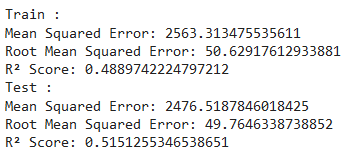

Results for XGBoost when deleting outliers :     

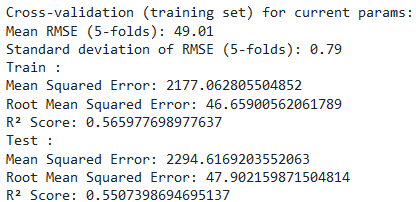

Results for linar regression when imputing outliers :

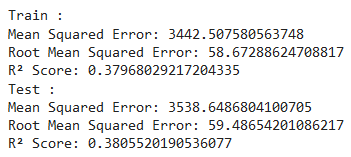

Results for XGBoosst when imputing outliers :

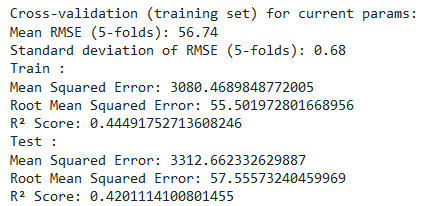

Version remplacing outliers (the call to the function is put as a comment # because it is not the version that we chose to keep.)

In [48]:
import numpy as np

def modified_z_score(data):
    # Calculate the modified Z-score
    median = np.median(data)
    mad = np.median(np.abs(data - median))  # Median Absolute Deviation
    return 0.6745 * (data - median) / mad

def replace_outliers_with_median(df):
    df_selected = df.drop(['bedrooms', 'bathrooms'], axis=1)

    for col in df_selected.select_dtypes(include=[np.number]):
        z_scores = modified_z_score(df[col])

        outliers = np.abs(z_scores) > 3.5 #Rule of gold

        # Replace outliers with the median value of the column
        median_value = df[col].median()
        df.loc[outliers, col] = median_value

    return df

#df = replace_outliers_with_median(df)

In [49]:
df.describe()

,id,host_id,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,maximum_nights,review_scores_location,amenities_number
count,3.029600e+04,3.029600e+04,30296.000000,30296.000000,30296.000000,30296.000000,30296.000000,30296.000000,30296.000000,30296.000000,30296.000000,30296.000000,30296.000000,30296.000000
mean,5.534714e+17,2.122717e+08,4.202865,41.891291,12.479824,3.793174,1.188955,1.387821,2.178411,213.213395,2.792910,373.648402,4.741478,32.505908
std,5.048970e+17,2.094661e+08,4.178708,0.036329,0.050065,1.987700,0.385872,0.652496,1.486476,653.457029,13.961126,423.045700,0.293280,14.791179
min,2.737000e+03,1.944000e+03,1.000000,41.655823,12.238500,1.000000,0.500000,0.000000,0.000000,8.000000,1.000000,1.000000,1.000000,1.000000
25%,2.920450e+07,2.353256e+07,1.000000,41.884056,12.459529,2.000000,1.000000,1.000000,1.000000,100.000000,1.000000,29.000000,4.670000,22.000000
50%,6.938908e+17,1.224222e+08,3.000000,41.896224,12.477262,4.000000,1.000000,1.000000,2.000000,142.000000,2.000000,365.000000,4.780000,33.000000
75%,1.051240e+18,4.310688e+08,5.000000,41.906442,12.504714,4.000000,1.000000,2.000000,3.000000,209.000000,3.000000,365.000000,4.950000,43.000000
max,1.242048e+18,6.511079e+08,21.000000,42.121310,12.835699,16.000000,2.000000,3.000000,38.000000,72000.000000,999.000000,1825.000000,5.000000,114.000000


Version deleting outliers

In [50]:
def remove_outliers(df):
    df_cleaned = df.copy()
    df_selected = df.drop(['bedrooms', 'bathrooms','host_total_listings_count'], axis=1)
    for col in df_selected.select_dtypes(include=[np.number]):
        z_scores = modified_z_score(df_cleaned[col])

        outliers = np.abs(z_scores) > 3.5 #Rule of gold

        df_cleaned = df_cleaned.loc[~outliers]

    return df_cleaned

df_cleaned = remove_outliers(df)

print(f"Number of lines before deleting : {df.shape[0]}")
print(f"Number of lines after : {df_cleaned.shape[0]}")

df = df_cleaned.copy()


Number of lines before deleting : 30296
Number of lines after : 24722


## Transformacion de variables

Columns for which we are doing a min-max transformation : numerical columns
- price
- accomodates
- bathrooms
- bedrooms
- beds
- minimum nights
- maximumm nigths
- amenities
- host_total_listings_count
- review_scores_location

Columns we are categorising : numerical columns with non-linear relationship with price
- latitude
- longitude

Column in which we are grouping into biger categories
- property type

Columns to which we are applying OneHotEncoding : not numerical columns
- neighbourhood
- property type
- room type
- latitude_bin (latitude after being put in a categorie)
- longitude_bin

We chose to use OneHotEncoding even though some of the variables we are applying it to have a lot of different values possible because it avoid implying an order between categories.

###Grouping into bigger categories

Printing the number of elements in each category to choose how to group them

In [51]:
property_type_counts = df_analisis['property_type'].value_counts()
print(property_type_counts)


property_type
Entire rental unit                    16230
Entire condo                           5610
Private room in rental unit            3702
Private room in bed and breakfast      1998
Private room in condo                  1146
Entire home                             990
Entire vacation home                    964
Entire loft                             484
Room in boutique hotel                  376
Private room in serviced apartment      340
Private room in home                    307
Room in hotel                           251
Entire serviced apartment               249
Room in bed and breakfast               241
Entire villa                            127
Private room in vacation home           102
Private room in guesthouse               95
Tiny home                                88
Shared room in rental unit               76
Room in serviced apartment               71
Private room in villa                    68
Private room in guest suite              61
Room in aparthotel

Grouping into categories in order to have at least 90 elements in each so the the category actualy means someting about the price.

In [52]:
df.loc[df['property_type'].str.contains('Shared room', na=False), 'property_type'] = 'Shared room'


In [53]:
# Count the number of lines with each possible value for property type
property_type_counts = df['property_type'].value_counts()

# Iterate over each property type
for property_type in property_type_counts.index:
  # Check if the property type contains 'Private room' and has less than 100 elements
  if 'Private room' in property_type and property_type_counts[property_type] < 100:
    # Change the property type to 'Private room' for all lines with this property type
    df.loc[df_analisis['property_type'] == property_type, 'property_type'] = 'Private room'


In [54]:
df.loc[df['property_type'].str.contains('Room', na=False), 'property_type'] = 'Room'

In [55]:
# Iterate over each property type
for property_type in property_type_counts.index:
  if 'Entire' in property_type and property_type_counts[property_type] < 120:
    df.loc[df_analisis['property_type'] == property_type, 'property_type'] = 'Entire place'

In [56]:
# Iterate over each property type
for property_type in property_type_counts.index:
  if property_type_counts[property_type] < 90:
    df.loc[df['property_type'] == property_type, 'property_type'] = 'Other'


Our new regrouped categories

In [57]:
property_type_counts = df['property_type'].value_counts()
print(property_type_counts)


property_type
Entire rental unit                    12249
Entire condo                           4421
Private room in rental unit            2521
Private room in bed and breakfast      1409
Private room in condo                   858
Entire vacation home                    755
Entire home                             584
Other                                   514
Room                                    513
Entire loft                             397
Private room in serviced apartment      202
Private room in home                    156
Entire serviced apartment               143
Name: count, dtype: int64


### Creating categories (with bins)

In [58]:
def putting_into_categories(df, target, bins=8):
    numeric_columns = ['latitude','longitude']
    for column in numeric_columns:
        df[f'{column}_bin'] = pd.qcut(df[column], q=bins, duplicates='drop',labels=False)

putting_into_categories(df, target='price')


In [59]:
df.head()

,id,host_id,host_total_listings_count,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,maximum_nights,review_scores_location,amenities_number,latitude_bin,longitude_bin
0,2737,3047,7,VIII Appia Antica,41.871360,12.482150,Other,Private room,1.0,1.5,1.0,1.0,56.0,7,1125,4.40,12,0,4
1,3079,3504,11,I Centro Storico,41.895000,12.491170,Entire rental unit,Entire home/apt,4.0,1.0,1.0,1.0,140.0,7,180,4.81,26,3,4
2,11834,44552,2,I Centro Storico,41.895447,12.491181,Entire rental unit,Entire home/apt,2.0,1.0,1.0,1.0,110.0,2,28,4.99,50,3,4
3,12398,11756,2,II Parioli/Nomentano,41.925820,12.469280,Entire rental unit,Entire home/apt,6.0,1.0,2.0,3.0,130.0,1,1125,4.89,44,7,2
4,19965,75450,9,I Centro Storico,41.907300,12.453490,Entire rental unit,Entire home/apt,5.0,1.0,2.0,3.0,168.0,3,365,4.89,49,6,1


###One Hot Encoding

In [60]:
df = pd.get_dummies(df, columns=["room_type","property_type","neighbourhood_cleansed","latitude_bin","longitude_bin"],drop_first=True)
display(df.head(2))

,id,host_id,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,...,latitude_bin_5,latitude_bin_6,latitude_bin_7,longitude_bin_1,longitude_bin_2,longitude_bin_3,longitude_bin_4,longitude_bin_5,longitude_bin_6,longitude_bin_7
0,2737,3047,7,41.87136,12.48215,1.0,1.5,1.0,1.0,56.0,...,False,False,False,False,False,False,True,False,False,False
1,3079,3504,11,41.89500,12.49117,4.0,1.0,1.0,1.0,140.0,...,False,False,False,False,False,False,True,False,False,False


### Min-max transformation

In [61]:
columns_minmax_transformation = ['price', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights', 'amenities_number','host_total_listings_count','review_scores_location']
scaler = MinMaxScaler()

for column in columns_minmax_transformation:
    df[column + '_minmax'] = scaler.fit_transform(df[[column]])


### Result of data transformation

In [62]:
df.head()

,id,host_id,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,...,longitude_bin_7,price_minmax,accommodates_minmax,bathrooms_minmax,bedrooms_minmax,beds_minmax,minimum_nights_minmax,amenities_number_minmax,host_total_listings_count_minmax,review_scores_location_minmax
0,2737,3047,7,41.871360,12.482150,1.0,1.5,1.0,1.0,56.0,...,False,0.119107,0.000000,0.666667,0.333333,0.142857,1.000000,0.132530,0.30,0.347826
1,3079,3504,11,41.895000,12.491170,4.0,1.0,1.0,1.0,140.0,...,False,0.327543,0.230769,0.333333,0.333333,0.142857,1.000000,0.301205,0.50,0.793478
2,11834,44552,2,41.895447,12.491181,2.0,1.0,1.0,1.0,110.0,...,False,0.253102,0.076923,0.333333,0.333333,0.142857,0.166667,0.590361,0.05,0.989130
3,12398,11756,2,41.925820,12.469280,6.0,1.0,2.0,3.0,130.0,...,False,0.302730,0.384615,0.333333,0.666667,0.428571,0.000000,0.518072,0.05,0.880435
4,19965,75450,9,41.907300,12.453490,5.0,1.0,2.0,3.0,168.0,...,False,0.397022,0.307692,0.333333,0.666667,0.428571,0.333333,0.578313,0.40,0.880435


In [63]:
df.columns

Index(['id', 'host_id', 'host_total_listings_count', 'latitude', 'longitude',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
       'minimum_nights', 'maximum_nights', 'review_scores_location',
       'amenities_number', 'room_type_Hotel room', 'room_type_Private room',
       'room_type_Shared room', 'property_type_Entire home',
       'property_type_Entire loft', 'property_type_Entire rental unit',
       'property_type_Entire serviced apartment',
       'property_type_Entire vacation home', 'property_type_Other',
       'property_type_Private room in bed and breakfast',
       'property_type_Private room in condo',
       'property_type_Private room in home',
       'property_type_Private room in rental unit',
       'property_type_Private room in serviced apartment',
       'property_type_Room', 'neighbourhood_cleansed_II Parioli/Nomentano',
       'neighbourhood_cleansed_III Monte Sacro',
       'neighbourhood_cleansed_IV Tiburtina', 'neighbourhood_cleansed_IX Eu

# b) Entrenamiento y Predicción

##Modelo 1 : Regresión lineal

Printing the new correlation matrix again now that we cleaned the data.

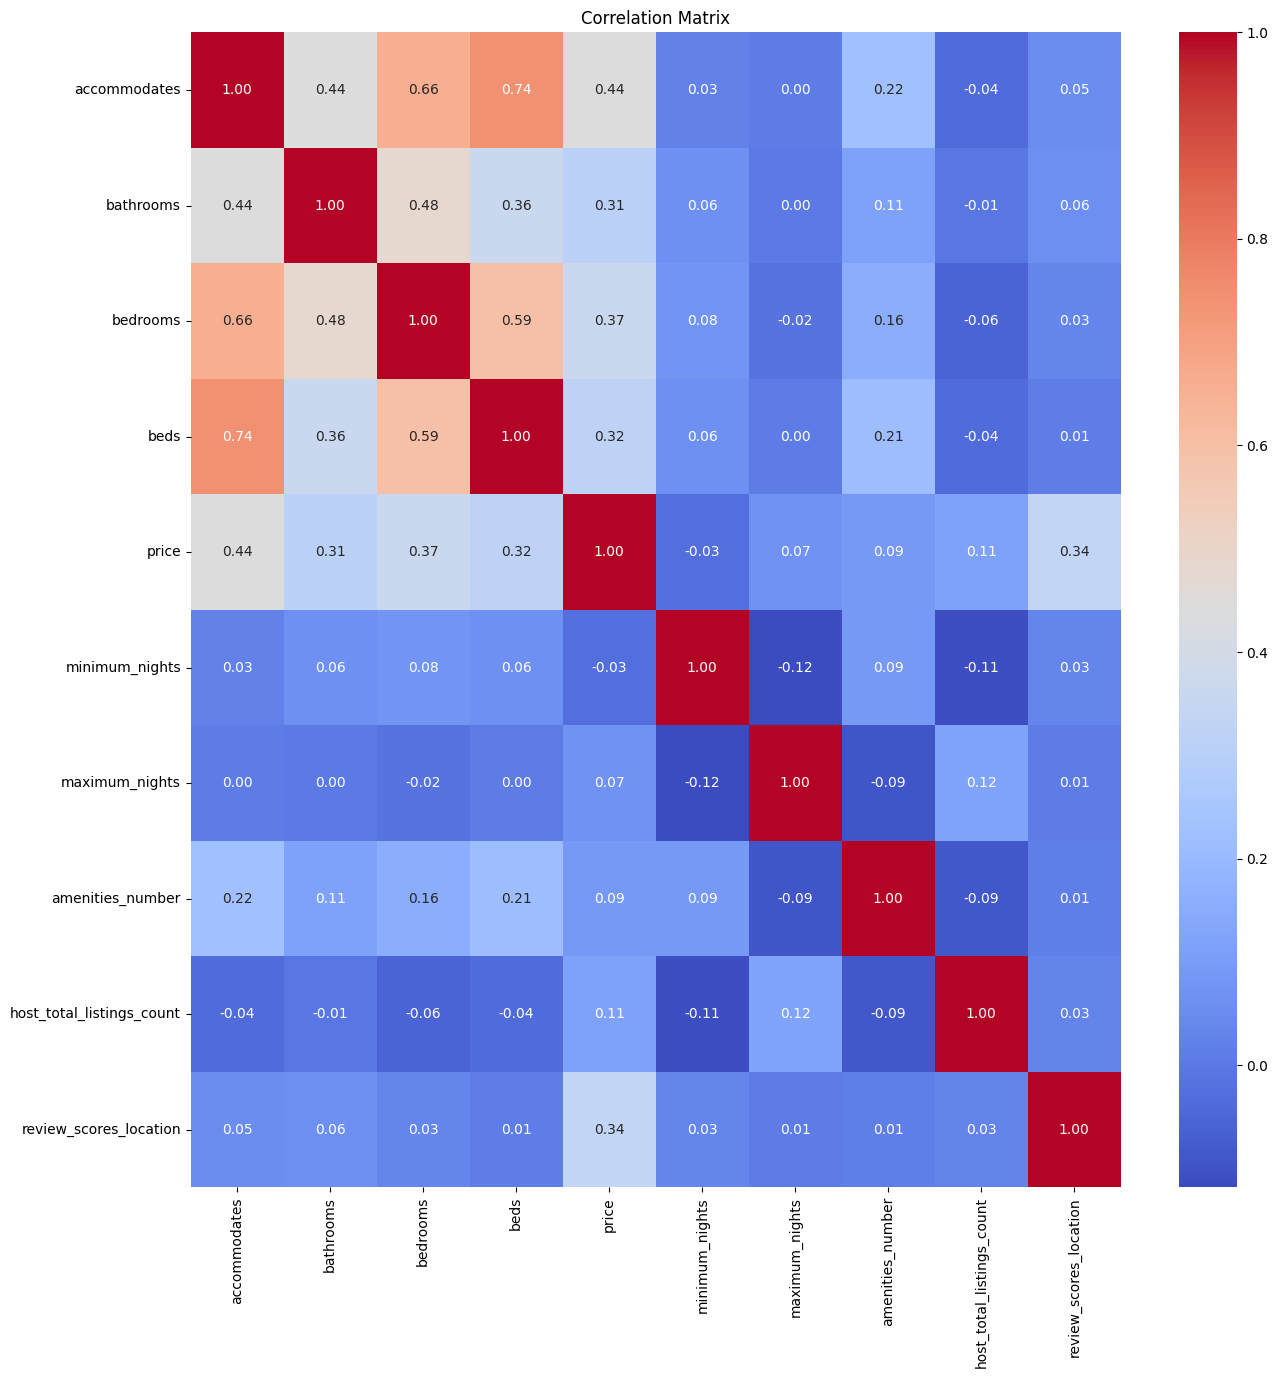

In [64]:
import matplotlib.pyplot as plt
correlation_matrix = df[['accommodates', 'bathrooms',
       'bedrooms', 'beds', 'price', 'minimum_nights', 'maximum_nights',
       'amenities_number','host_total_listings_count','review_scores_location']].corr()
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


According to the correlation matrix some of the variable have a very little correlated with the price (minimum_nights for example). But I tried to make the linear regression without it and the result was less good.

We also have some variables that are very correlated between each other (accomodate, bedroom, bathroom, bed) I tried to only keep some of the but once again the result was less good then with keeping all of them.

Thus all of the variables from the above correlation matrix were kept in the models.

#### Building Linear Regression model

In [65]:
#Creo un regresor lineal
modelo_lineal_multiple = LinearRegression()

#Doy el formato adecuado a las variables dependiente e independiente
caracteristicas=df[[
       'room_type_Hotel room', 'room_type_Private room',
       'room_type_Shared room', 'property_type_Entire home',
       'property_type_Entire loft', 'property_type_Entire rental unit',
       'property_type_Entire vacation home', 'property_type_Other',
       'property_type_Private room in bed and breakfast',
       'property_type_Private room in condo',
       'property_type_Private room in home',
       'property_type_Private room in rental unit',
       'property_type_Private room in serviced apartment',
       'property_type_Room', 'neighbourhood_cleansed_II Parioli/Nomentano',
       'neighbourhood_cleansed_III Monte Sacro',
       'neighbourhood_cleansed_IV Tiburtina', 'neighbourhood_cleansed_IX Eur',
       'neighbourhood_cleansed_V Prenestino/Centocelle',
       'neighbourhood_cleansed_VI Roma delle Torri',
       'neighbourhood_cleansed_VII San Giovanni/Cinecittà',
       'neighbourhood_cleansed_VIII Appia Antica',
       'neighbourhood_cleansed_XI Arvalia/Portuense',
       'neighbourhood_cleansed_XII Monte Verde',
       'neighbourhood_cleansed_XIII Aurelia',
       'neighbourhood_cleansed_XIV Monte Mario',
       'neighbourhood_cleansed_XV Cassia/Flaminia',
       'latitude_bin_1', 'latitude_bin_2',
       'latitude_bin_3', 'latitude_bin_4', 'latitude_bin_5',
       'latitude_bin_6', 'latitude_bin_7', 'longitude_bin_1',
       'longitude_bin_2', 'longitude_bin_3', 'longitude_bin_4',
       'longitude_bin_5', 'longitude_bin_6', 'longitude_bin_7',
       'accommodates_minmax', 'bathrooms_minmax',
       'bedrooms_minmax', 'beds_minmax', 'minimum_nights_minmax',
       'amenities_number_minmax', 'host_total_listings_count_minmax',
       'review_scores_location_minmax']]
price=df['price'].values.reshape(-1, 1)

#Division del conjunto 80-20%
caracteristicas_train, caracteristicas_test, price_train, price_test = train_test_split(caracteristicas, price, test_size=0.2, random_state=42)

#Ajusto el modelo
modelo_lineal_multiple.fit(caracteristicas_train ,price_train)

# Coeficientes estimados
coeficientes = modelo_lineal_multiple.coef_[0]
intercepto = round(modelo_lineal_multiple.intercept_[0], 2)

# Muestro el modelo
print(f"El modelo lineal multiple ajustado es :")

for i, nombre_columna in enumerate(caracteristicas.columns):
    coeficiente = round(coeficientes[i], 2)
    print(f"{coeficiente} * {nombre_columna}")

print(f"+ {intercepto}")

El modelo lineal multiple ajustado es :
-22.19 * room_type_Hotel room
-14.46 * room_type_Private room
-62.92 * room_type_Shared room
7.41 * property_type_Entire home
-3.87 * property_type_Entire loft
-0.73 * property_type_Entire rental unit
0.61 * property_type_Entire vacation home
3.48 * property_type_Other
24.52 * property_type_Private room in bed and breakfast
-2.88 * property_type_Private room in condo
7.79 * property_type_Private room in home
3.23 * property_type_Private room in rental unit
29.43 * property_type_Private room in serviced apartment
48.47 * property_type_Room
-19.77 * neighbourhood_cleansed_II Parioli/Nomentano
-25.98 * neighbourhood_cleansed_III Monte Sacro
-24.7 * neighbourhood_cleansed_IV Tiburtina
-0.0 * neighbourhood_cleansed_IX Eur
-17.69 * neighbourhood_cleansed_V Prenestino/Centocelle
-6.82 * neighbourhood_cleansed_VI Roma delle Torri
1.13 * neighbourhood_cleansed_VII San Giovanni/Cinecittà
-40.46 * neighbourhood_cleansed_VIII Appia Antica
-19.24 * neighbourh

#### Results from train and test

In [66]:
#Train
price_pred_train=modelo_lineal_multiple.predict(caracteristicas_train)

# Result
mse_train = metrics.mean_squared_error(price_train, price_pred_train)
rmse_train = np.sqrt(mse_train)
r2_train = metrics.r2_score(price_train, price_pred_train)

print("Train :")
print(f"Mean Squared Error: {mse_train}")
print(f"Root Mean Squared Error: {rmse_train}")
print(f"R² Score: {r2_train}")

#Test
#Prediccion sobre casos nuevos con mis modelos ya entrenados
price_pred_test = modelo_lineal_multiple.predict(caracteristicas_test)

# Result
mse_test = metrics.mean_squared_error(price_test, price_pred_test)
rmse_test = np.sqrt(mse_test)
r2_test = metrics.r2_score(price_test, price_pred_test)

print("Test :")
print(f"Mean Squared Error: {mse_test}")
print(f"Root Mean Squared Error: {rmse_test}")
print(f"R² Score: {r2_test}")

Train :
Mean Squared Error: 3098.840295822466
Root Mean Squared Error: 55.66722820315797
R² Score: 0.4861681005653814
Test :
Mean Squared Error: 2909.5969080867776
Root Mean Squared Error: 53.94067952933832
R² Score: 0.478094187036603


####Signification of diferent metrics
- The value of rmse is the average distance between the real and the predicted price.

- The value of mse is rmse².
The lower rmse and mse we get, the better.

- R² is the proportion of the variability of the price that can be explained by the features. The closest it is to 1 the better the model explains the variability.

#### Result analisis :
- Our value of R² is about 0.5, which means our model explains 50% of the variance in the price.

- The rmse is lower in the tests then on the training, which is good because it means our model isn't overfitting.

- The standard deviation for the price is 71 (see result of the code below), thus an RMSE of 50 is good even though it could propably be improved by optimisating the model more.

In [67]:
std_price = df['price'].std()
print(f"Standard deviation for the price : {std_price}")

Standard deviation for the price : 77.07909893291838


Version using crossed validation

In [68]:
caracteristicas_train, caracteristicas_test, price_train, price_test = train_test_split(
    caracteristicas, price, test_size=0.3, random_state=42)

model_linear = LinearRegression()

# Cross validation (5-folds)
cv_scores_mse = cross_val_score(model_linear, caracteristicas_train, price_train, cv=5, scoring='neg_mean_squared_error')
cv_scores_rmse = np.sqrt(-cv_scores_mse)

# Results
print("Cross-validation (training set) :")
print(f"Mean RMSE (5-folds): {np.mean(cv_scores_rmse):.2f}")
print(f"Standard deviation of RMSE (5-folds): {np.std(cv_scores_rmse):.2f}")

Cross-validation (training set) :
Mean RMSE (5-folds): 55.74
Standard deviation of RMSE (5-folds): 1.03


We chose 5 folds as the dataset is large so it seems sufficent.

We find a mean rmse similar to the rmse we found without crossvalidation, and a small standard deviation which indicate the model's stability.

## Modelo 2 : XGBoost

#### XGBoost testing different hyperparameters
- n_estimators : total number of boosting iterations (trees)
- max_depth : maximum depth of each tree
- learning_rate: how much the model adjusts at each step
- subsample : proprotion of the training data used for each round   

In [69]:
caracteristicas_train, caracteristicas_test, price_train, price_test = train_test_split(
    caracteristicas, price, test_size=0.3, random_state=42)
price_train = price_train.ravel()  # Aplatir au cas où ce soit nécessaire
price_test = price_test.ravel()

model_XGBoost = XGBRegressor(objective='reg:squarederror', booster='gbtree')

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

results = []

for n_estimators in param_grid['n_estimators']:
    for max_depth in param_grid['max_depth']:
        for learning_rate in param_grid['learning_rate']:
            for subsample in param_grid['subsample']:
                model_XGBoost = XGBRegressor(objective='reg:squarederror', booster='gbtree',
                                             n_estimators=n_estimators, max_depth=max_depth,
                                             learning_rate=learning_rate, subsample=subsample)

                model_XGBoost.fit(caracteristicas_train, price_train)

                #Train
                price_pred_train = model_XGBoost.predict(caracteristicas_train)

                mse_train = metrics.mean_squared_error(price_train, price_pred_train)
                rmse_train = np.sqrt(mse_train)
                r2_train = metrics.r2_score(price_train, price_pred_train)

                #Test
                price_pred_test = model_XGBoost.predict(caracteristicas_test)

                mse_test = metrics.mean_squared_error(price_test, price_pred_test)
                rmse_test = np.sqrt(mse_test)
                r2_test = metrics.r2_score(price_test, price_pred_test)

                results.append({
                    'n_estimators': n_estimators,
                    'max_depth': max_depth,
                    'learning_rate': learning_rate,
                    'subsample': subsample,
                    'train_mse': mse_train,
                    'train_rmse': rmse_train,
                    'train_r2': r2_train,
                    'test_mse': mse_test,
                    'test_rmse': rmse_test,
                    'test_r2': r2_test
                })

results_df = pd.DataFrame(results)

print("\nSummary of results:")
print(results_df)


Summary of results:
    n_estimators  max_depth  learning_rate  subsample    train_mse  \
0            100          3           0.01        0.8  4267.677724   
1            100          3           0.01        1.0  4276.222576   
2            100          3           0.10        0.8  2865.372474   
3            100          3           0.10        1.0  2878.073707   
4            100          5           0.01        0.8  3836.948411   
5            100          5           0.01        1.0  3847.637754   
6            100          5           0.10        0.8  2438.480121   
7            100          5           0.10        1.0  2472.129585   
8            100          7           0.01        0.8  3486.251690   
9            100          7           0.01        1.0  3501.960076   
10           100          7           0.10        0.8  1922.945428   
11           100          7           0.10        1.0  1965.690248   
12           200          3           0.01        0.8  3678.466921   

A good result is one where we have the smallest test rmse possible but also a small distance between the test rmse and train rmse to avoid overfitting.

The smallest rmse with a small test-train difference is with parameters (line 14) :    
- n_estimators = 200  
- max_depth = 3
- learning_rate = 0.1
- subsample = 0.8

With
- train rmse = 51.67
- test rmse = 52.62

The results are better then with the linear regression model even though I would have expected a bigger difference.

#### XGBoost model with crossvalidation and the hyperparameters we found

In [70]:
model_XGBoost = XGBRegressor(objective='reg:squarederror', booster='gbtree',
                                             n_estimators=200, max_depth=3,
                                             learning_rate=0.1, subsample=0.8)
model_XGBoost.fit(caracteristicas_train, price_train)

# Cross-validation (5-folds)
cv_scores_mse = cross_val_score(model_XGBoost, caracteristicas_train, price_train, cv=5, scoring='neg_mean_squared_error')
cv_scores_rmse = np.sqrt(-cv_scores_mse)  # Convertir les scores MSE en RMSE

print(f"Cross-validation (training set) for current params:")
print(f"Mean RMSE (5-folds): {np.mean(cv_scores_rmse):.2f}")
print(f"Standard deviation of RMSE (5-folds): {np.std(cv_scores_rmse):.2f}")

#Train
# Predictions
price_pred_train = model_XGBoost.predict(caracteristicas_train)

# Result
mse = metrics.mean_squared_error(price_train, price_pred_train)
rmse = np.sqrt(mse)
r2 = metrics.r2_score(price_train, price_pred_train)

print("Train :")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R² Score: {r2}")

#Test
# Predictions
price_pred_test = model_XGBoost.predict(caracteristicas_test)

# Result
mse = metrics.mean_squared_error(price_test, price_pred_test)
rmse = np.sqrt(mse)
r2 = metrics.r2_score(price_test, price_pred_test)

print("Test :")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R² Score: {r2}")


Cross-validation (training set) for current params:
Mean RMSE (5-folds): 53.32
Standard deviation of RMSE (5-folds): 1.14
Train :
Mean Squared Error: 2670.2222936202866
Root Mean Squared Error: 51.67419369105131
R² Score: 0.5570098874335265
Test :
Mean Squared Error: 2768.8253437109715
Root Mean Squared Error: 52.619628882299914
R² Score: 0.5173964496506809


The cross-validation has a low standard deviation which is good.

## Modelo 3 : Random Forest    

#### Random forest model with crossfold validation

In [71]:
caracteristicas_train, caracteristicas_test, price_train, price_test = train_test_split(
    caracteristicas, price, test_size=0.3, random_state=42)

price_train = price_train.ravel()
price_test = price_test.ravel()

model_rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Crossfold validation (5-folds)
cv_scores_mse = cross_val_score(model_rf, caracteristicas_train, price_train, cv=5, scoring='neg_mean_squared_error')
cv_scores_rmse = np.sqrt(-cv_scores_mse)  # Convertir les scores MSE en RMSE

# Results
print("Cross-validation (training set) :")
print(f"Mean RMSE (5-folds): {np.mean(cv_scores_rmse):.2f}")
print(f"Standard deviation of RMSE (5-folds): {np.std(cv_scores_rmse):.2f}")

model_rf.fit(caracteristicas_train, price_train)

#Train
price_pred_train = model_rf.predict(caracteristicas_train)

mse_train = metrics.mean_squared_error(price_train, price_pred_train)
rmse_train = np.sqrt(mse_train)
r2_train = metrics.r2_score(price_train, price_pred_train)

print("\nTrain :")
print(f"Mean Squared Error (MSE): {mse_train:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_train:.2f}")
print(f"R² Score: {r2_train:.2f}")

#Test
price_pred_test = model_rf.predict(caracteristicas_test)

mse_test = metrics.mean_squared_error(price_test, price_pred_test)
rmse_test = np.sqrt(mse_test)
r2_test = metrics.r2_score(price_test, price_pred_test)

print("\nTest :")
print(f"Mean Squared Error (MSE): {mse_test:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_test:.2f}")
print(f"R² Score: {r2_test:.2f}")


Cross-validation (training set) :
Mean RMSE (5-folds): 54.81
Standard deviation of RMSE (5-folds): 0.84

Train :
Mean Squared Error (MSE): 418.29
Root Mean Squared Error (RMSE): 20.45
R² Score: 0.93

Test :
Mean Squared Error (MSE): 2948.72
Root Mean Squared Error (RMSE): 54.30
R² Score: 0.49


With random forest we have a similar rmse then with XGBoost.
The results are also better with training then with testing but with a much bigger difference which means we have an overfitting issue.
We can try to improve that by modifying the hyper parameters.

#### Trying with different values of max_depth for the trees

In [72]:
caracteristicas_train, caracteristicas_test, price_train, price_test = train_test_split(
    caracteristicas, price, test_size=0.3, random_state=42)
price_train = price_train.ravel()
price_test = price_test.ravel()

max_depth_values = [5, 7, 9]
results = []

for max_depth in max_depth_values:
    print(f"\nTesting for max_depth = {max_depth}")

    model_rf = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=max_depth)

    # Cross validation (5-folds)
    cv_scores_mse = cross_val_score(model_rf, caracteristicas_train, price_train, cv=5, scoring='neg_mean_squared_error')
    cv_scores_rmse = np.sqrt(-cv_scores_mse)

    print(f"Cross-validation (training set) for max_depth={max_depth}:")
    print(f"Mean RMSE (5-folds): {np.mean(cv_scores_rmse):.2f}")
    print(f"Standard deviation of RMSE (5-folds): {np.std(cv_scores_rmse):.2f}")

    model_rf.fit(caracteristicas_train, price_train)

    price_pred_train = model_rf.predict(caracteristicas_train)

    mse_train = metrics.mean_squared_error(price_train, price_pred_train)
    rmse_train = np.sqrt(mse_train)
    r2_train = metrics.r2_score(price_train, price_pred_train)

    price_pred_test = model_rf.predict(caracteristicas_test)

    mse_test = metrics.mean_squared_error(price_test, price_pred_test)
    rmse_test = np.sqrt(mse_test)
    r2_test = metrics.r2_score(price_test, price_pred_test)

    results.append({
        'max_depth': max_depth,
        'train_mse': mse_train,
        'train_rmse': rmse_train,
        'train_r2': r2_train,
        'test_mse': mse_test,
        'test_rmse': rmse_test,
        'test_r2': r2_test
    })

results_df = pd.DataFrame(results)

print("\nSummary of results:")
print(results_df)



Testing for max_depth = 5
Cross-validation (training set) for max_depth=5:
Mean RMSE (5-folds): 60.56
Standard deviation of RMSE (5-folds): 1.19

Testing for max_depth = 7
Cross-validation (training set) for max_depth=7:
Mean RMSE (5-folds): 58.03
Standard deviation of RMSE (5-folds): 1.20

Testing for max_depth = 9
Cross-validation (training set) for max_depth=9:
Mean RMSE (5-folds): 56.44
Standard deviation of RMSE (5-folds): 1.14

Summary of results:
   max_depth    train_mse  train_rmse  train_r2     test_mse  test_rmse  \
0          5  3581.082550   59.842147  0.405898  3549.441763  59.577192   
1          7  3128.693553   55.934726  0.480949  3247.887888  56.990244   
2          9  2641.207239   51.392677  0.561823  3089.130386  55.579946   

    test_r2  
0  0.381336  
1  0.433896  
2  0.461568  


The rmse is higher for a smaller maximal depth, but it reduces the overfitting.

The parameters max_depth = 7 seem like good a option to keep the rmse test value not to high while also not having a model that overfits the training data.

We have train rmse = 55.93 and test rmse = 56.99 which is a little bit worse then the two previous models. But limiting the depth to 7 for exemple is a good way to avoid overfiting.

# c) Cuadrado de Resultado


Result for each model with the most efficient hyperparameters that were found :


|**Model**                   |**RMSE test**|**RMSE train**|**R²**  |
|----------------------------|-------------|--------------|--------|
| Model 1 (Linear Regression)| 53.94       | 55.67        | 0.48 |
| Model 2 (XGBoost)          | 52.62       | 51.67        | 0.52 |
| Model 3 (Random Forest)    | 56.99       | 55.93        | 0.43 |

Between the tree models that we tried, with the way we cleaned and transformed the data the most efficient one is XGBoost.

The most efficient hyperparameters for this model were :
- n_estimators = 200
- max_depth = 3
- learning_rate = 0.1
- subsample = 0.8

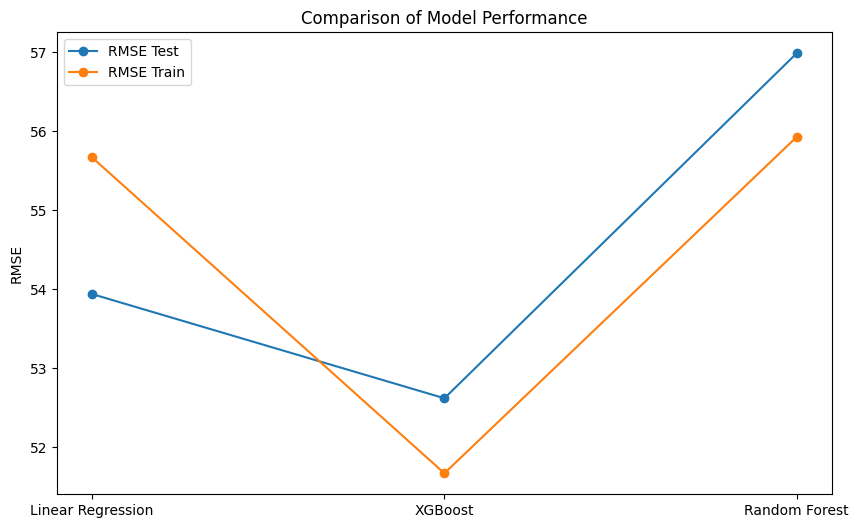

In [73]:
models = ['Linear Regression', 'XGBoost', 'Random Forest']
rmse_train = [55.67, 51.67, 55.93]
rmse_test = [53.94, 52.62, 56.99]
r2 = [0.48, 0.52, 0.43]

x = range(len(models))

plt.figure(figsize=(10, 6))

plt.plot(x, rmse_test, label='RMSE Test', marker='o')
plt.plot(x, rmse_train, label='RMSE Train', marker='o')

plt.xticks(x, models)
plt.ylabel('RMSE')
plt.title('Comparison of Model Performance')
plt.legend()

plt.show()

# Descarga de los datos por github

Conjuncto de datos

In [74]:
df.to_csv('listings_long_modified.csv', index=False)

In [75]:
from google.colab import files
files.download('listings_long_modified.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Modelos

In [76]:
import joblib

joblib.dump(modelo_lineal_multiple, 'modelo_lineal_multiple.joblib')
joblib.dump(model_linear, 'modelo_lineal_crossvalidation.joblib')
joblib.dump(model_XGBoost, 'modelo_XGBoost.joblib')
model_rf = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=7)
model_rf.fit(caracteristicas_train, price_train)
joblib.dump(model_rf, 'model_RandomForest_depth7.joblib')



['model_RandomForest_depth7.joblib']

In [77]:
from google.colab import files
files.download('modelo_lineal_multiple.joblib')
files.download('modelo_lineal_crossvalidation.joblib')
files.download('modelo_XGBoost.joblib')
files.download('model_RandomForest_depth7.joblib')




<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>